In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.mixture import BayesianGaussianMixture

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

In [14]:
def moments(row):
    idade = row['idade']
    renda_mensal = row['renda_mensal']
    investimento_total = row['investimento_total']
    
    if 0 <= idade < 16:
        return 'Momento 1'
    elif 16 <= idade < 26:
        return 'Momento 2'
    elif 26 <= idade < 60:
        if renda_mensal >= 5e3:
            if investimento_total < 2e5:
                return 'Momento 6'
            else:
                return 'Momento 7'
        elif (idade < 36) and (renda_mensal < 5e3):
            return 'Momento 3'
        elif (idade < 45) and (renda_mensal < 5e3):
            return 'Momento 4'
        elif renda_mensal < 5e3:
            return 'Momento 5'
    elif idade >= 60:
        if renda_mensal < 5e3:
            return 'Momento 8'
        else:
            return 'Momento 9'

def wage_cat(data):
    
    qt_30 = data['renda_mensal'].quantile(.3)
    qt_70 = data['renda_mensal'].quantile(.7)
    qt_90 = data['renda_mensal'].quantile(.9)

    return data\
        .assign(
            categoria_renda=lambda x: (
                x\
                    .renda_mensal\
                    .apply(
                        lambda renda: (
                            'BAIXISSIMA' if renda <= qt_30 else
                            'CLASSE MÉDIA - NORMAL' if renda <= qt_70 else
                            'CLASSE MÉDIA - ALTA' if renda <= qt_90 else
                            'ALTA RENDA'
                    )
                )
            )
        )

In [15]:
df = pd.read_csv(
    'ldw-base_relacionamento_atual.csv',
    delimiter=';',
    dtype={'cod_carteira': str}
    )\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str,
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0}),
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        desc_cbo=lambda x: x.desc_cbo.replace('ESTUDANTE', 'Estudantes'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        investimento_total=lambda x: x.sld_lci + x.sld_lca + x.sld_fundos + x.sld_dep_a_prazo,
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ],
    )\
    .query(
        '(status_associado == "ATIVO") '
        'and ~renda_mensal.isna() '
        'and (segmento != "AG")'
    )\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola',
            'vlr_prej_cred_rural', 'mc_seguro_rural'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)
        

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[
    (df.idade <= 15) &
    (df.renda_mensal >= 0),
    'renda_mensal'] = 0

df.loc[
    (df.idade >= 16) &
    (df.renda_mensal < 1000) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = df.sld_cred_scr_2m * .3

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = np.nan

df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('mean')

In [ ]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal
df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1),
        alavancagem=lambda x: (x.sld_cred_scr_2m / x.renda_mensal).replace(np.inf, 0).fillna(0),
    )\
    .reset_index(drop=True)#\
    #.query('desc_cbo != "Diretor de produção e operações em empresa pesqueira"')\
df.loc[
    df.desc_cbo == "Diretor de produção e operações em empresa pesqueira",
    'renda_mensal'] = 11826.12


df = wage_cat(df)

#### Cooperativas Geral

In [17]:
df_cluster = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'isa', 'sld_previdencia',
        'sld_inad_ca_0', 
        'investimento_total',
        'tempo_assoc', 'score_principalidade',
        ] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist() +
        df.columns[df.columns.str.startswith('mc_') & ~df.columns.isin([
            'mc_assoc', 'mc_assoc_6_meses', 'mc_total'
        ])].tolist() +
        df.filter(like='vlr_prej').columns.tolist()
    ]\
    .drop(
        columns=[
            'sld_seg_patrimonial', 'sld_seg_rural',
            'sld_seg_out_familias', 'sld_cred_coobrigacoes',
            'sld_cred_direcionados', 'vlr_prej_direcionados',
            'mc_seguro_prestamista', 'mc_seguro_patrimonial',
            'sld_cred_rural', 'mc_cred_direcionados',
            'mc_folha_pgmt', 'mc_lci', 'mc_cambio',
            'mc_adq', 'mc_pagamento_fornecedor',
            'mc_cred_rural', 'mc_custodia_cheques',
        ]
    )
    #.drop(
    #    columns=[
    #        'sld_seg_patrimonial', 'sld_seg_rural',
    #        'sld_seg_out_familias', 'sld_cred_coobrigacoes',
    #        'sld_cred_direcionados', #'vlr_prej_direcionados',
    #        #'mc_seguro_prestamista', 'mc_seguro_patrimonial',
    #        'sld_cred_rural', #'mc_cred_direcionados',
    #        #'mc_folha_pgmt', 'mc_lci', 'mc_cambio',
    #        #'mc_adq', 'mc_pagamento_fornecedor',
    #        #'mc_cred_rural', 'mc_custodia_cheques',
    #    ]
    #)

df_cluster_columns = df_cluster.columns.tolist()
df_cluster = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster),
    columns=df_cluster_columns
    )\
    .assign(
        #idade=lambda x: 25 * x.idade,
        #renda_mensal=lambda x: 25 * x.renda_mensal
    )

In [364]:
#corr = df_cluster.corr(method='spearman')
#mask = np.triu(np.ones_like(corr, dtype=bool))
#f, ax = plt.subplots(figsize=(11, 9))
#
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [45]:
class Inertia: 
    def __init__(self, data, cluster_columns=None, set_groups=20):
        self.set_groups = set_groups + 1
        self.data = data
        self.data_cluster = data.loc[:, cluster_columns]
        self.cluster_columns = cluster_columns

    def find_groups(self, n_clusters):
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            random_state=42
            ).fit(self.data_cluster)\
            .labels_
    
    def calc_inertia(self):
        return [
            KMeans(
                n_clusters=i,
                init='k-means++',
                random_state=42
            ).fit(self.data_cluster)\
            .labels_
            for i in range(1, self.set_groups)
        ]

    def plot_inertia(self):
        plt.figure(figsize=(10, 8))
        plt.plot(
            range(1, self.set_groups),
            self.calc_inertia(),
            marker='o', 
            linestyle='--'
        )

In [44]:
def choose_seed(data, n_clusters=7):
    for seed in range(101):
        kmeans = KMeans(
            n_clusters=n_clusters,
            max_iter=5000,
            tol=1e-16,
            random_state=seed
        ).fit(data)
        _, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        print(f"Number of elements assigned to each cluster: {cluster_sizes}, {seed}")

In [394]:
choose_seed(df_cluster)

Number of elements assigned to each cluster: [  321 47703   264    58  4663 81957 23395], 0
Number of elements assigned to each cluster: [22649 81895  5653   366    75 47722     1], 1
Number of elements assigned to each cluster: [104380     12      6    400    150  52462    951], 2
Number of elements assigned to each cluster: [ 52008     39    946 104967     12    380      9], 3
Number of elements assigned to each cluster: [ 5539 47350   389 81915    46 22497   625], 4
Number of elements assigned to each cluster: [85778   381 51159     9     1 20958    75], 5
Number of elements assigned to each cluster: [ 4609 82117 23300   349 47805    17   164], 6
Number of elements assigned to each cluster: [84708 21234 50766   654     7   425   567], 7
Number of elements assigned to each cluster: [21809   683 81927  6029   279 47559    75], 8
Number of elements assigned to each cluster: [47962 22268  5763    75 82009     6   278], 9
Number of elements assigned to each cluster: [55715   734  5673 95

In [390]:
#bgmm = BayesianGaussianMixture(
#    n_components=7,
#    tol=1e-16,
#    max_iter=100,
#    random_state=42
#)
#bgmm.fit(df_cluster)
#df = df\
#    .assign(
#        bgmm_grupos=bgmm.fit_predict(df_cluster)
#    )

In [395]:
kmeans = KMeans(
    n_clusters=7,
    tol=1e-16,
    max_iter=5000,
    random_state=14
    ).fit(df_cluster)

In [396]:
df = df.assign(
    Grupos=kmeans.labels_
    )\
    .sort_values('Grupos')\
    .astype({'Grupos': str})

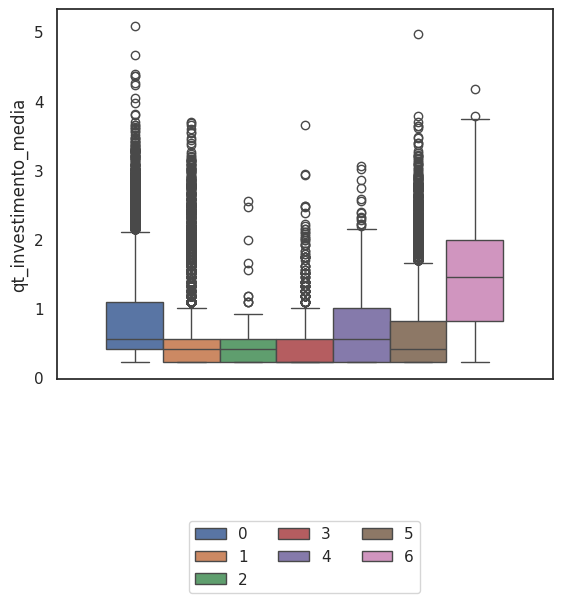

In [399]:
sns.boxplot(
    data=df\
        .assign(qt_investimento_media=lambda x: np.log1p(x.qt_investimento_media))\
        .query('qt_investimento_media != 0'),
    y='qt_investimento_media',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

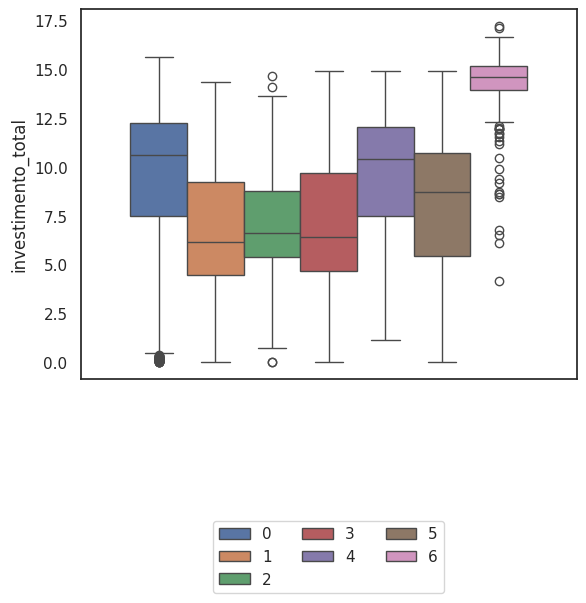

In [400]:
sns.boxplot(
    data=df\
        .assign(investimento_total=lambda x: np.log1p(x.investimento_total))\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

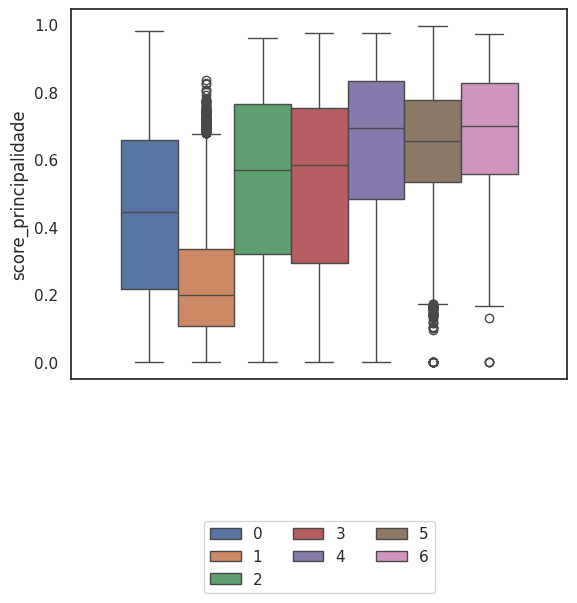

In [401]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='score_principalidade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

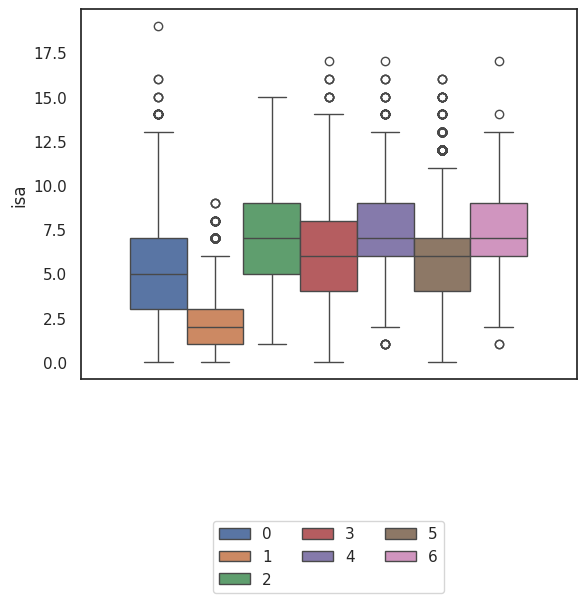

In [402]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='isa',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

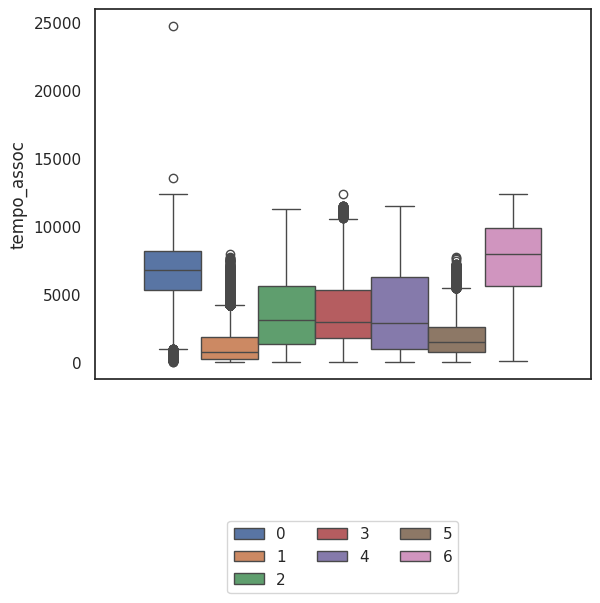

In [403]:
sns.boxplot(
    data=df,
    y='tempo_assoc',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

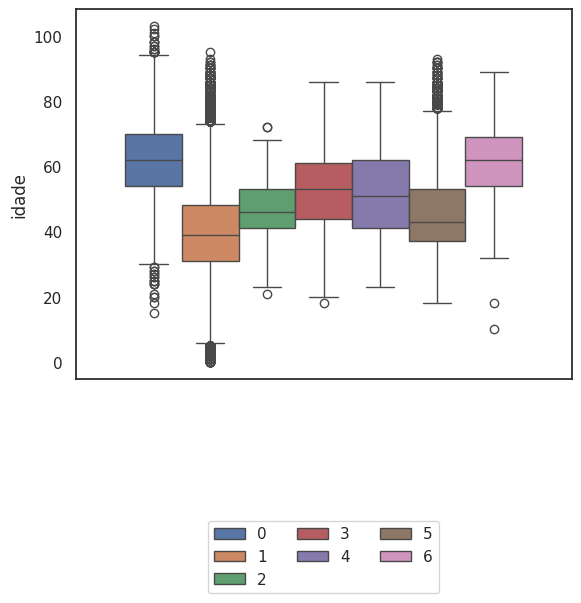

In [404]:
sns.boxplot(
    data=df,
    y='idade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

<Axes: ylabel='renda_mensal'>

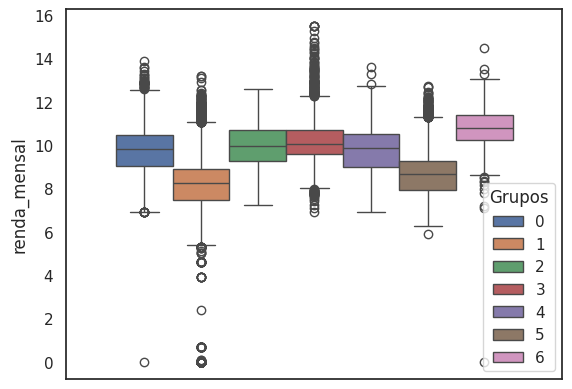

In [405]:
sns.boxplot(
    data=df\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

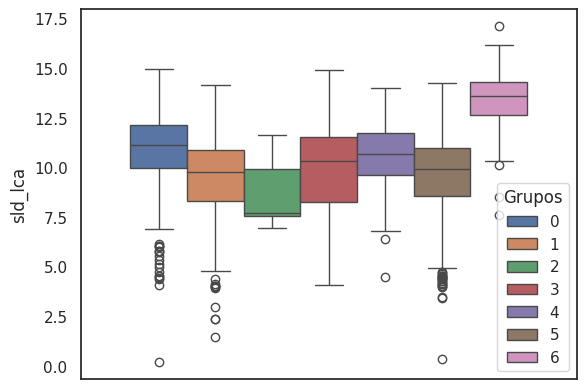

In [406]:
sns.boxplot(
    data=df\
        .assign(
            sld_lca=lambda x: np.log1p(x.sld_lca)
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_prestamista'>

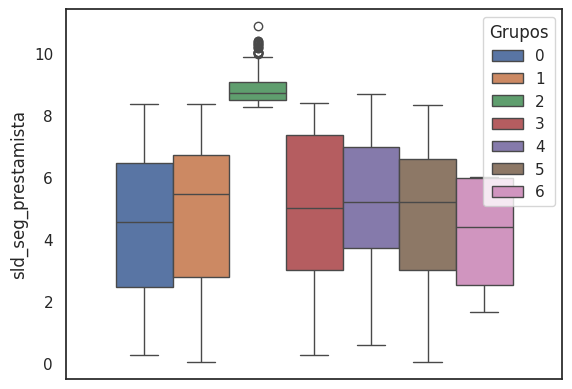

In [407]:
sns.boxplot(
    data=df\
        .assign(
            sld_seg_prestamista=lambda x: np.log1p(x.sld_seg_prestamista)
        )\
        .query('sld_seg_prestamista != 0'),
    y='sld_seg_prestamista',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

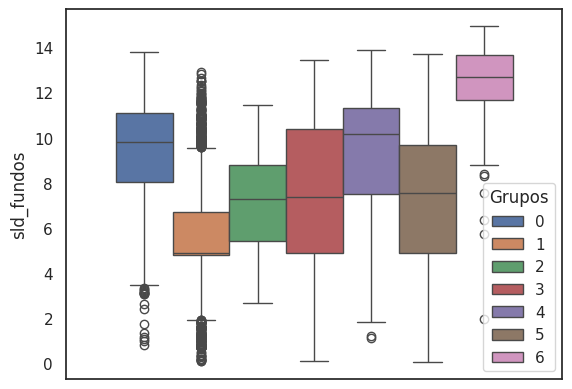

In [409]:
sns.boxplot(
    data=df\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_vida'>

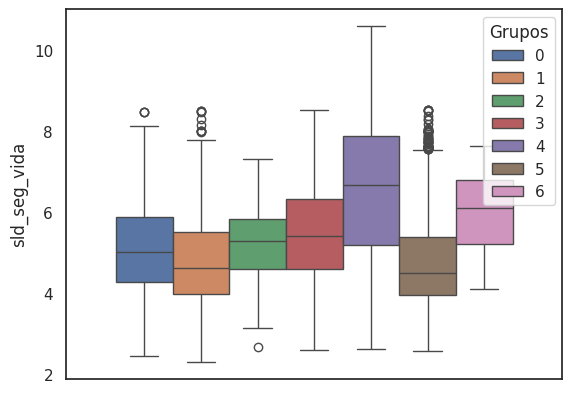

In [410]:
sns.boxplot(
    data=df\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida)
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

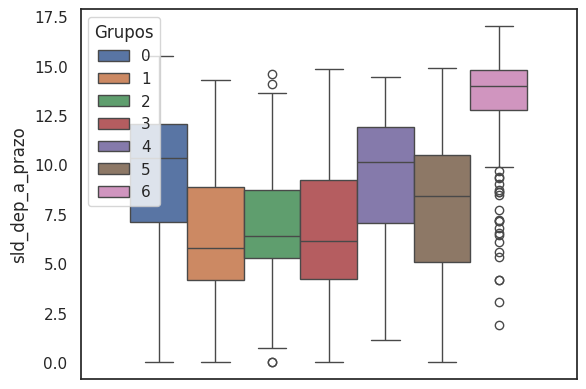

In [411]:
sns.boxplot(
    data=df\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo)
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_poupanca'>

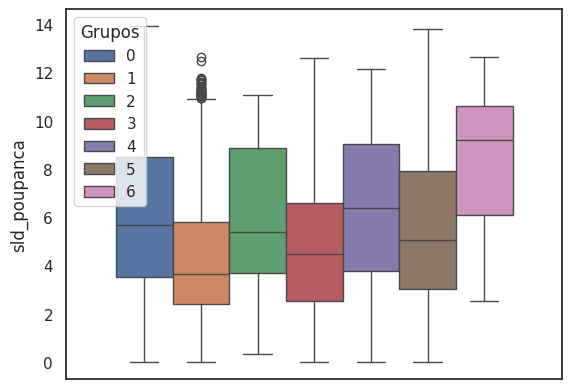

In [479]:
sns.boxplot(
    data=df\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca)
        )\
        .query('sld_poupanca != 0'),
    y='sld_poupanca',
    hue='Grupos'
)

<Axes: ylabel='sld_previdencia'>

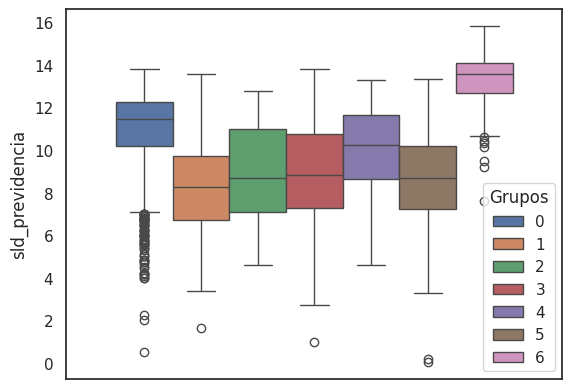

In [413]:
sns.boxplot(
    data=df\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: xlabel='idade', ylabel='renda_mensal'>

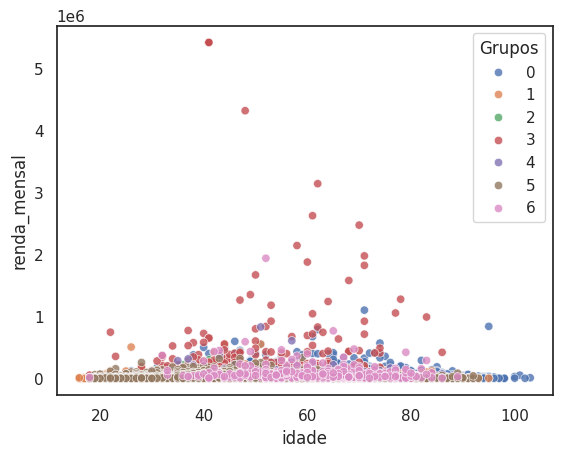

In [414]:
sns.scatterplot(
    data=df\
        .query('renda_mensal != 0'),
    x='idade',
    y='renda_mensal',
    alpha=.8,
    hue='Grupos'
)

## Grupo 0

In [450]:
df_0 = df.query('Grupos == "0"')
df_cluster_0 = df_0.loc[:, df_cluster_columns]\
    .drop(columns=['idade', 'renda_mensal'])#\
    #.loc[:, [
    #    'idade', 'renda_mensal',
    #    'isa',
    #    'investimento_total',
    #    'tempo_assoc', 'score_principalidade']
    #    ]

df_cluster_0 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_0),
    columns=df_cluster_0.columns.tolist()
    )

In [43]:
def plot_inercia(data):
    range_n_clusters = range(1, 11)
    inertia = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=42,
            tol=1e-16,
            max_iter=5000
            )
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range_n_clusters, inertia, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.xticks(range_n_clusters)
    plt.grid(True)
    plt.show()

In [452]:
choose_seed(df_cluster_0, n_clusters=4)

Number of elements assigned to each cluster: [13348  7716   396   197], 0
Number of elements assigned to each cluster: [  170  8207   376 12904], 1
Number of elements assigned to each cluster: [  393   228  7660 13376], 2
Number of elements assigned to each cluster: [ 8150 12617   517   373], 3
Number of elements assigned to each cluster: [13473     1   397  7786], 4
Number of elements assigned to each cluster: [ 1052 12165  7936   504], 5
Number of elements assigned to each cluster: [19712    16   422  1507], 6
Number of elements assigned to each cluster: [20803   206   406   242], 7
Number of elements assigned to each cluster: [12653  8331   313   360], 8
Number of elements assigned to each cluster: [  346 20703   183   425], 9
Number of elements assigned to each cluster: [  246  6166 13039  2206], 10
Number of elements assigned to each cluster: [ 7843 12389  1055   370], 11
Number of elements assigned to each cluster: [ 1051  7869 12364   373], 12
Number of elements assigned to each

In [453]:
kmeans_0 = KMeans(
    n_clusters=4,
    tol=1e-16,
    max_iter=5000,
    random_state=100
    ).fit(df_cluster_0)
df_0 = df_0.assign(
    subgrupo=kmeans_0.labels_
)

<Axes: ylabel='idade'>

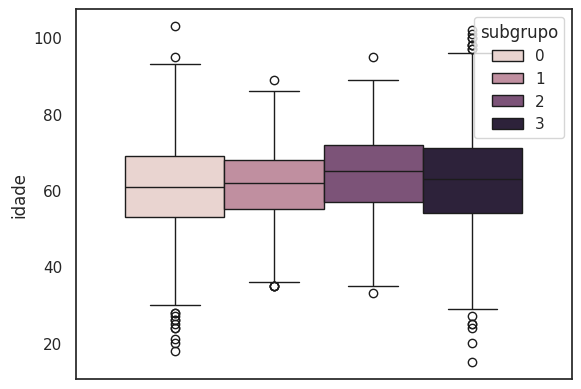

In [454]:
sns.boxplot(
    data=df_0,
    y='idade',
    hue='subgrupo'
)

<Axes: ylabel='score_principalidade'>

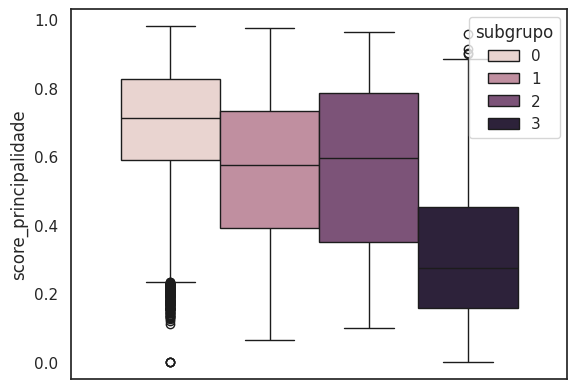

In [455]:
sns.boxplot(
    data=df_0,
    y='score_principalidade',
    hue='subgrupo'
)

<Axes: ylabel='sld_dep_a_prazo'>

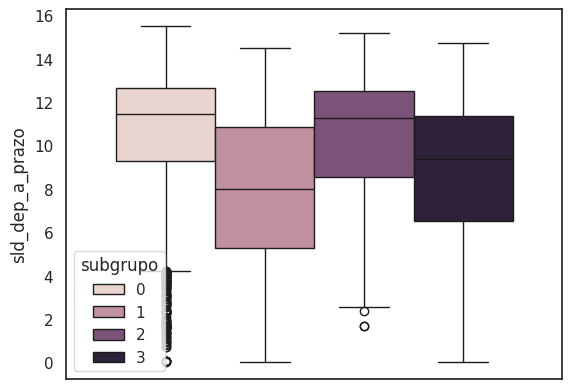

In [456]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo)
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='subgrupo'
)

<Axes: ylabel='investimento_total'>

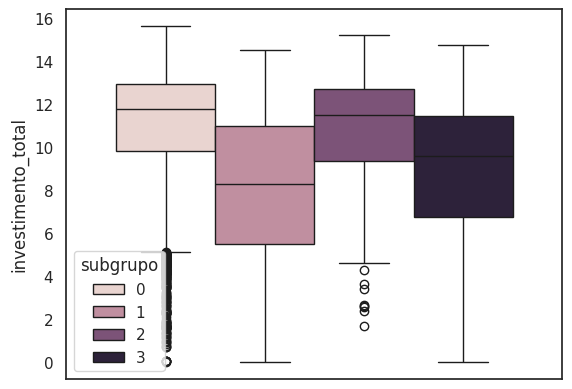

In [457]:
sns.boxplot(
    data=df_0\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total)
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='subgrupo'
)

<Axes: ylabel='sld_lci'>

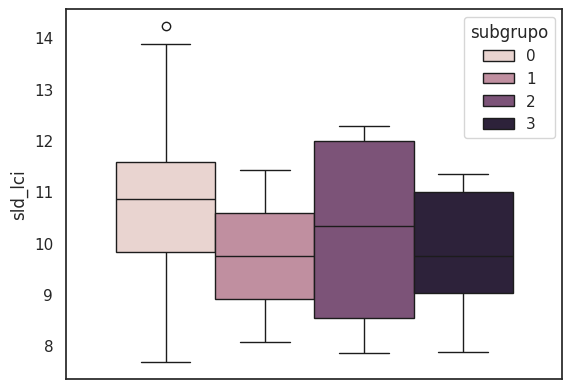

In [474]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lci)
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='subgrupo'
)

<Axes: ylabel='sld_lci'>

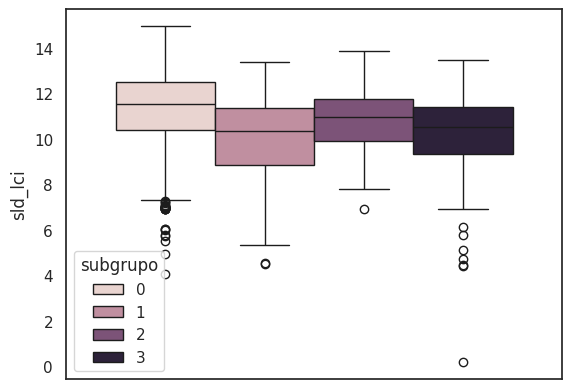

In [473]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lca)
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='subgrupo'
)

<Axes: ylabel='sld_seg_residencial'>

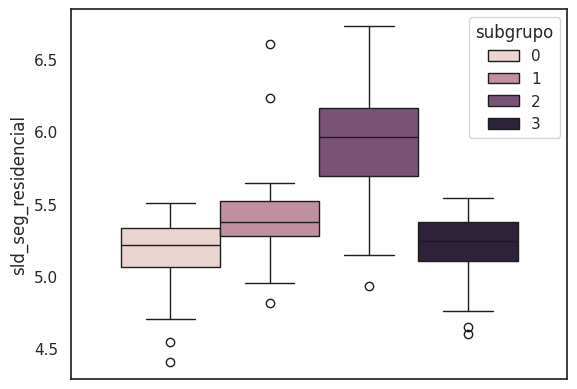

In [472]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_seg_residencial=lambda x: np.log1p(x.sld_seg_residencial)
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='subgrupo'
)

<Axes: ylabel='sld_seg_patrimonial'>

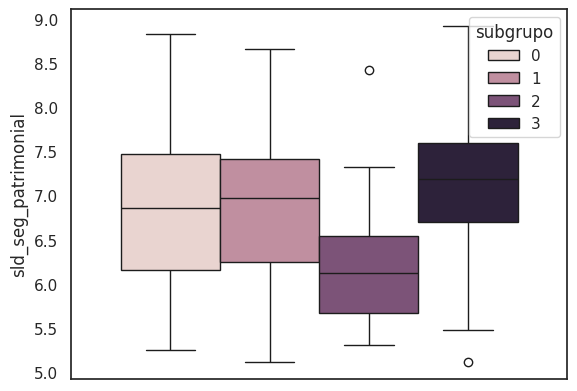

In [460]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_seg_patrimonial=lambda x: np.log1p(x.sld_seg_patrimonial)
        )\
        .query('sld_seg_patrimonial != 0'),
    y='sld_seg_patrimonial',
    hue='subgrupo'
)

<Axes: ylabel='sld_seg_vida'>

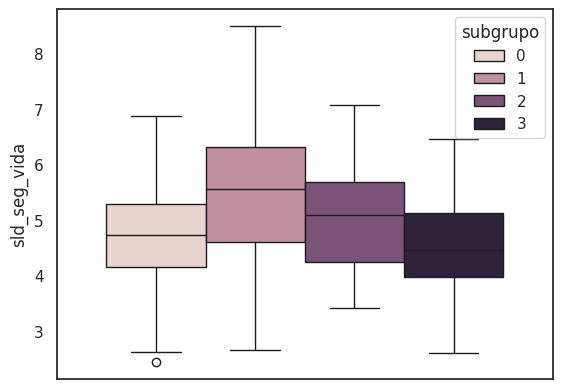

In [461]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida)
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='subgrupo'
)

<Axes: ylabel='sld_previdencia'>

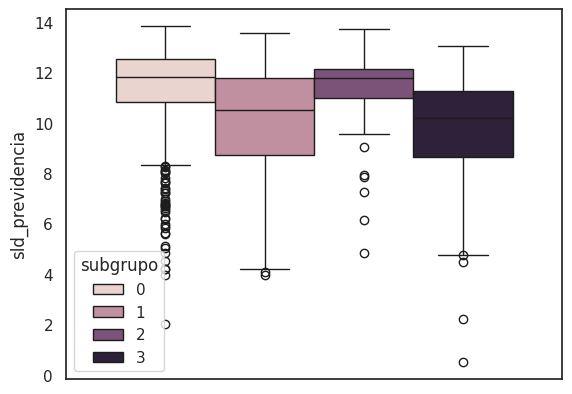

In [468]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='subgrupo'
)

<Axes: ylabel='sld_seg_residencial'>

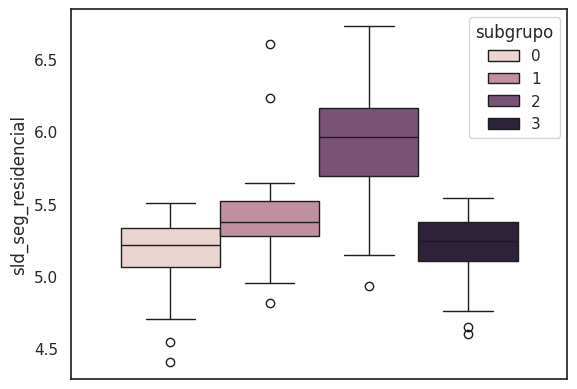

In [469]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_seg_residencial=lambda x: np.log1p(x.sld_seg_residencial)
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='subgrupo'
)

<Axes: ylabel='sld_poupanca'>

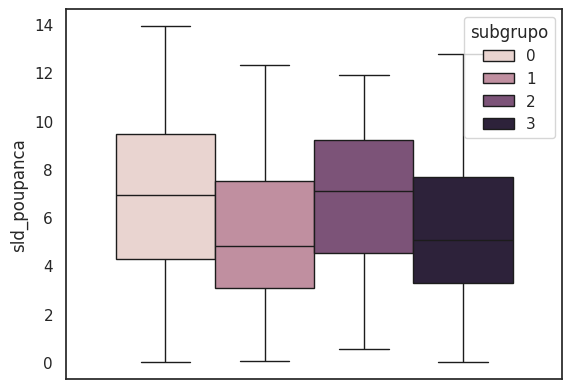

In [480]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca)
        )\
        .query('sld_poupanca != 0'),
    y='sld_poupanca',
    hue='subgrupo'
)

<Axes: ylabel='sld_seg_automovel'>

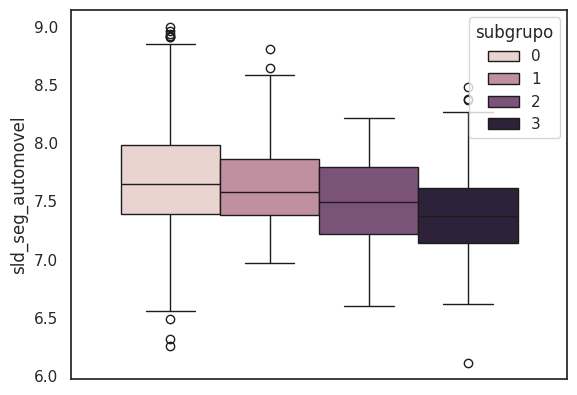

In [470]:
sns.boxplot(
    data=df_0\
        .assign(
            sld_seg_automovel=lambda x: np.log1p(x.sld_seg_automovel)
        )\
        .query('sld_seg_automovel != 0'),
    y='sld_seg_automovel',
    hue='subgrupo'
)

<Axes: ylabel='renda_mensal'>

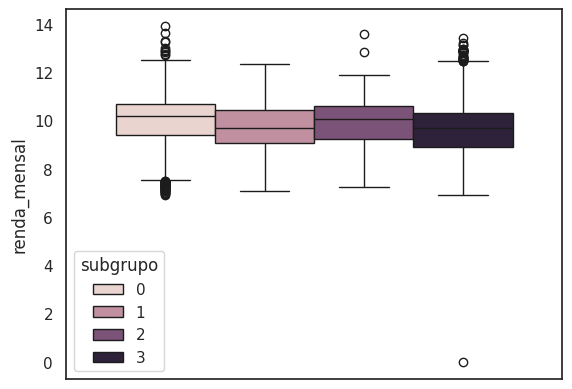

In [471]:
sns.boxplot(
    data=df_0\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='subgrupo'
)

## Grupos 1

In [330]:
df_1 = df.query('Grupos == "1"')
df_cluster_1 = df_1.loc[:, df_cluster_columns]#\
    #.drop(columns=['idade'])
df_cluster_1 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_1),
    columns=df_cluster_1.columns.tolist()
    )

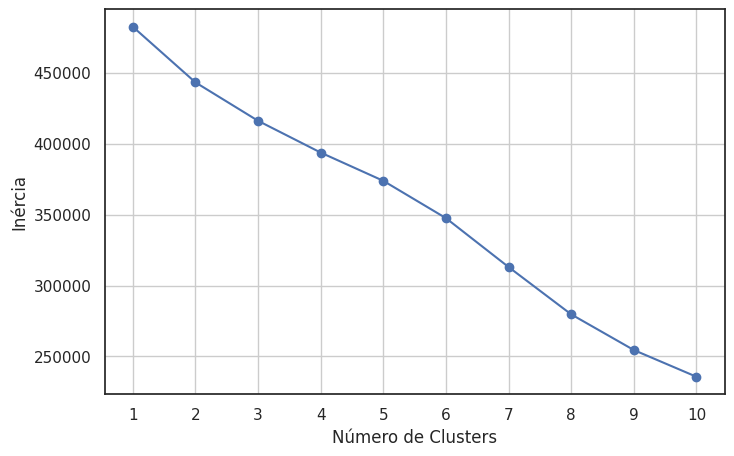

In [331]:
plot_inercia(df_cluster_1)

In [333]:
choose_seed(df_cluster_1, n_clusters=4)

Number of elements assigned to each cluster: [25609 11063   152   278], 0
Number of elements assigned to each cluster: [  615 20442  5167 10878], 1
Number of elements assigned to each cluster: [ 4443 13022  5553 14084], 2
Number of elements assigned to each cluster: [14865  8956 13003   278], 3
Number of elements assigned to each cluster: [10822   151 25651   478], 4
Number of elements assigned to each cluster: [ 9340  5837  9395 12530], 5
Number of elements assigned to each cluster: [13269   152  8824 14857], 6
Number of elements assigned to each cluster: [13056 14059  4442  5545], 7
Number of elements assigned to each cluster: [11065   278 25607   152], 8
Number of elements assigned to each cluster: [13184  8798   278 14842], 9
Number of elements assigned to each cluster: [ 8318 19203  4202  5379], 10
Number of elements assigned to each cluster: [13022  4443 14084  5553], 11
Number of elements assigned to each cluster: [  640  8470 14240 13752], 12
Number of elements assigned to each

In [335]:
kmeans_1 = KMeans(
    n_clusters=4,
    tol=1e-16,
    max_iter=5000,
    random_state=17
    ).fit(df_cluster_1)
df_1 = df_1.assign(
    subgrupo=kmeans_1.labels_
)

<Axes: ylabel='idade'>

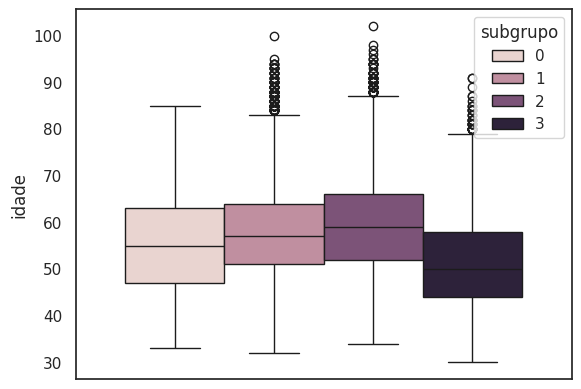

In [339]:
sns.boxplot(
    data=df_1,
    y='idade',
    hue='subgrupo'
)

<Axes: ylabel='renda_mensal'>

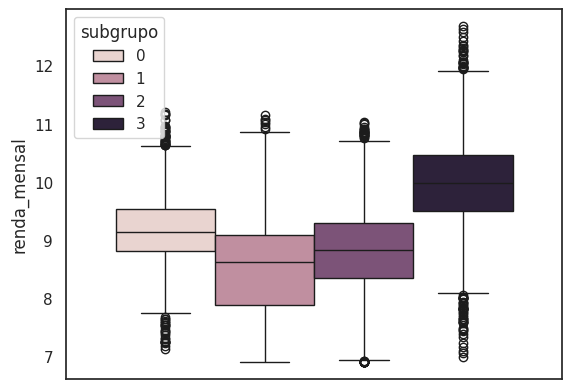

In [ ]:
sns.boxplot(
    data=df_1\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='subgrupo'
    )

<Axes: ylabel='sld_seg_automovel'>

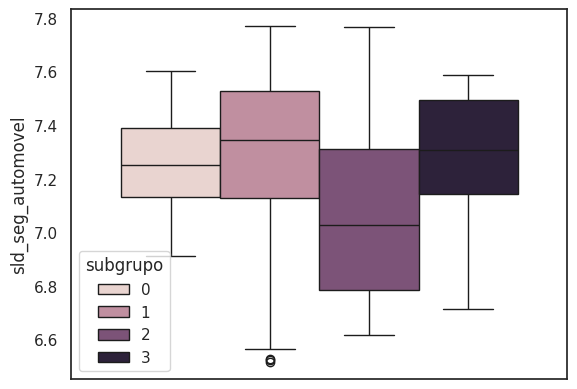

In [340]:
sns.boxplot(
    data=df_1\
        .assign(
            sld_seg_automovel=lambda x: np.log1p(x.sld_seg_automovel)
        )\
        .query('sld_seg_automovel != 0'),
    y='sld_seg_automovel',
    hue='subgrupo'
)

In [304]:
#prod_tot = df\
#    .loc[:, df.columns.str.startswith('prod_')]\
#    .stack()\
#    .reset_index(name='possui')\
#    .rename(columns={'level_1': 'produto'})\
#    .drop(columns=['level_0'])\
#    .astype({'possui': int})\
#    .groupby('produto').possui\
#    .sum().reset_index()\
#    .assign(
#        possui=lambda x: (x.possui / df.shape[0]) * 100
#    )\
#    .sort_values('possui')

In [39]:
#df.to_csv('relacionamento_clusters.csv', index=False)

## Coop - 2307

In [36]:
df_2307 = df.query('cod_coop == "2307"')

df_cluster_2307 = df_2307\
    .loc[:, df_cluster_columns]

df_cluster_2307 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_2307),
    columns=df_cluster_columns
    )

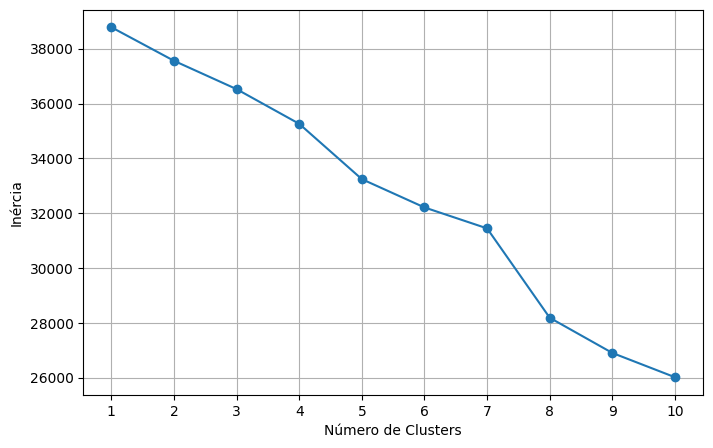

In [50]:
plot_inercia(df_cluster_2307)

In [51]:
choose_seed(df_cluster_2307, n_clusters=6)

Number of elements assigned to each cluster: [201 285 620 100   1   5], 0
Number of elements assigned to each cluster: [962  51 195   2   1   1], 1
Number of elements assigned to each cluster: [276 719  31   2  16 168], 2
Number of elements assigned to each cluster: [ 98  11 142 291 669   1], 3
Number of elements assigned to each cluster: [295  32 141 646  96   2], 4
Number of elements assigned to each cluster: [671 288 143 101   5   4], 5
Number of elements assigned to each cluster: [151  11  18 904 127   1], 6
Number of elements assigned to each cluster: [  5 674  99 144   1 289], 7
Number of elements assigned to each cluster: [110 355 435  38 199  75], 8
Number of elements assigned to each cluster: [155 206   1 843   4   3], 9
Number of elements assigned to each cluster: [343   1   1  27 735 105], 10
Number of elements assigned to each cluster: [ 42 291 653 147  75   4], 11
Number of elements assigned to each cluster: [ 30 732  15  11 257 167], 12
Number of elements assigned to each

In [55]:
kmeans_2307 = KMeans(
    n_clusters=6,
    tol=1e-16,
    max_iter=5000,
    random_state=8
    ).fit(df_cluster_2307)
df_2307 = df_2307.assign(
    Grupos=kmeans_2307.labels_
).astype({'Grupos': str})

<Axes: ylabel='idade'>

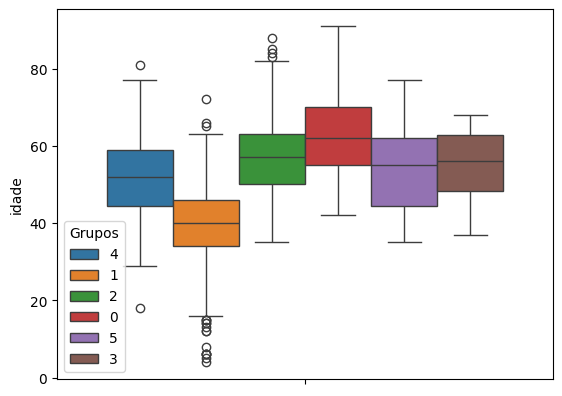

In [61]:
sns.boxplot(
    data=df_2307,
    y='idade',
    hue='Grupos'
)

<Axes: ylabel='renda_mensal'>

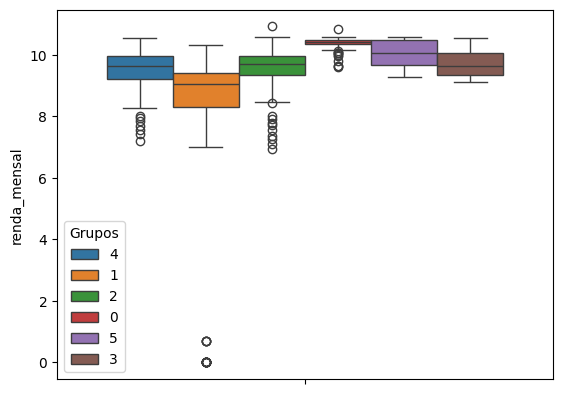

In [63]:
sns.boxplot(
    data=df_2307\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='Grupos'
    )

<Axes: ylabel='sld_seg_vida'>

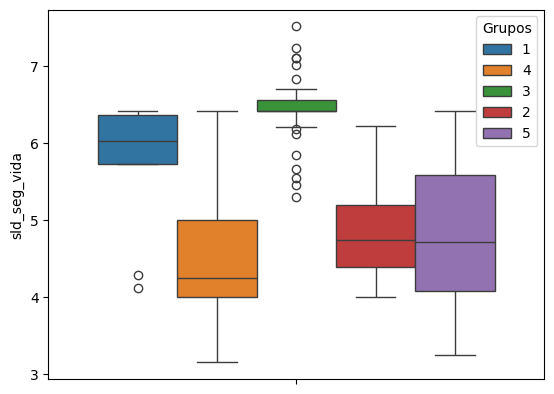

In [65]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida)
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_residencial'>

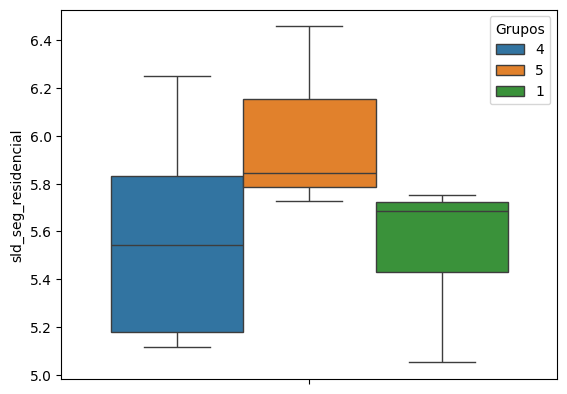

In [67]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_seg_residencial=lambda x: np.log1p(x.sld_seg_residencial)
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_prestamista'>

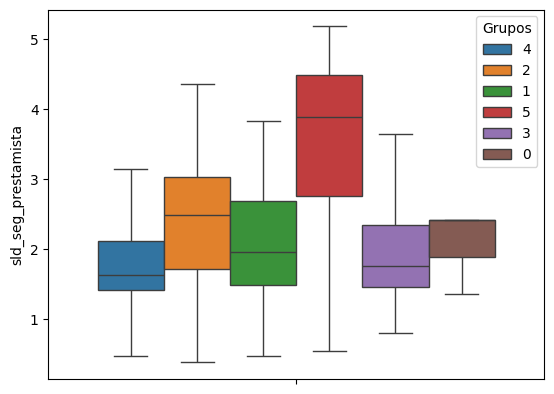

In [66]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_seg_prestamista=lambda x: np.log1p(x.sld_seg_prestamista)
        )\
        .query('sld_seg_prestamista != 0'),
    y='sld_seg_prestamista',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

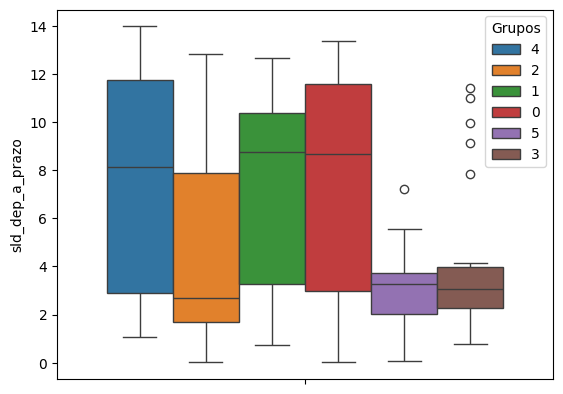

In [72]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo)
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

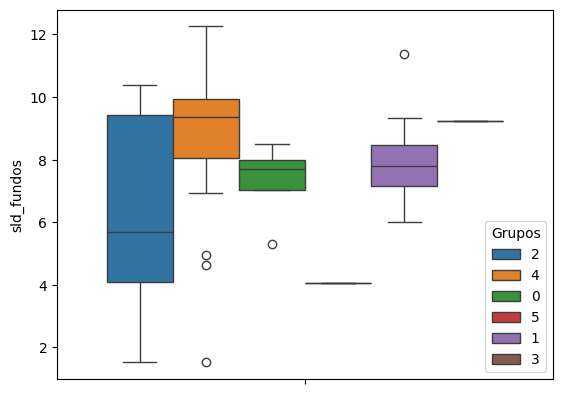

In [73]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

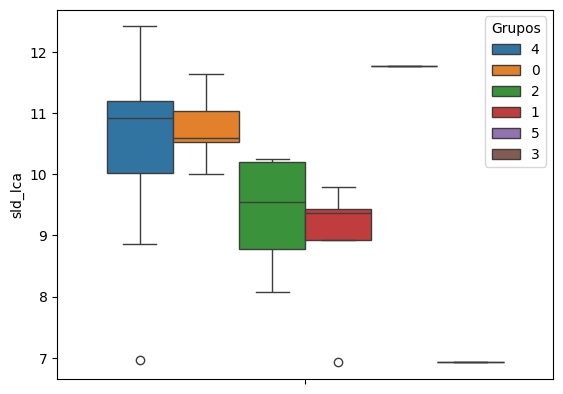

In [ ]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_lca=lambda x: np.log1p(x.sld_lca)
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='grupos'
)

<Axes: ylabel='investimento_total'>

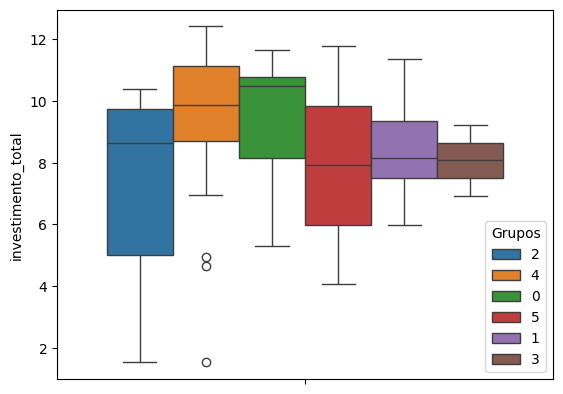

In [74]:
sns.boxplot(
    data=df_2307\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total - x.sld_dep_a_prazo) 
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos'
)

<Axes: ylabel='sld_inad_ca_0'>

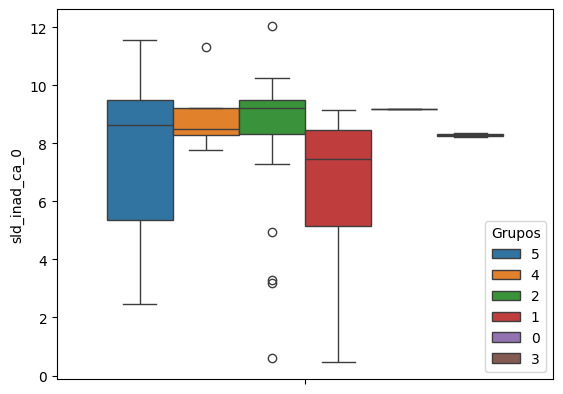

In [88]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_inad_ca_0=lambda x: np.log1p(x.sld_inad_ca_0)
        )\
        .query('sld_inad_ca_0 != 0'),
    y='sld_inad_ca_0',
    hue='Grupos'
)

<Axes: ylabel='prej_total'>

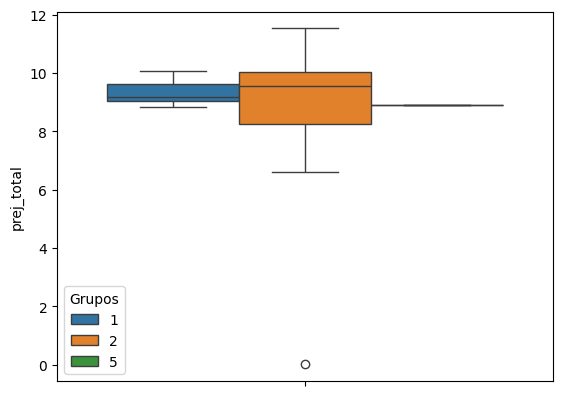

In [81]:
sns.boxplot(
    data=df_2307\
        .assign(
            prej_total=lambda x: np.log1p(x.loc[:, x.columns.str.startswith('vlr_prej')].sum(axis=1))
        )\
        .query('prej_total != 0'),
    y='prej_total',
    hue='Grupos'
)

<Axes: ylabel='sld_poupanca'>

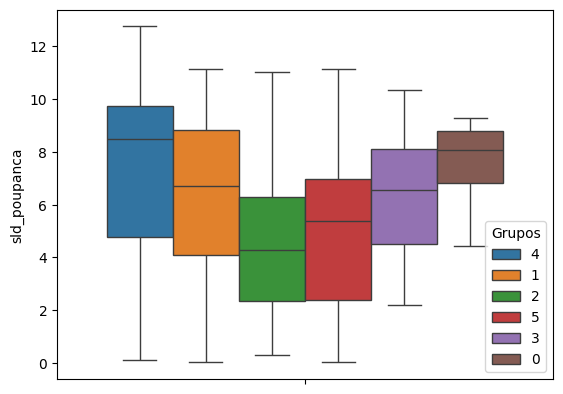

In [90]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca)
        )\
        .query('sld_poupanca != 0'),
        
    y='sld_poupanca',
    hue='Grupos'
)

<Axes: ylabel='sld_previdencia'>

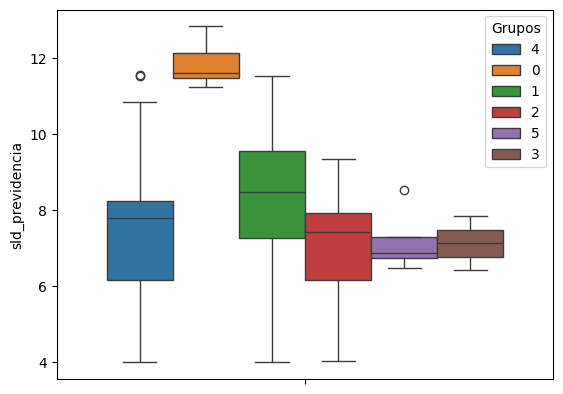

In [89]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_automovel'>

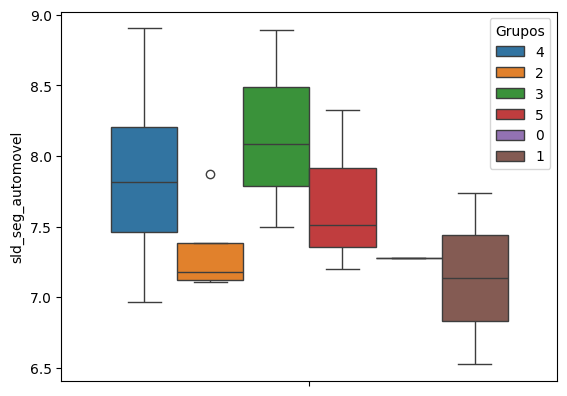

In [64]:
sns.boxplot(
    data=df_2307\
        .assign(
            sld_seg_automovel=lambda x: np.log1p(x.sld_seg_automovel)
        )\
        .query('sld_seg_automovel != 0'),
    y='sld_seg_automovel',
    hue='Grupos'
)

<Axes: xlabel='idade', ylabel='renda_mensal'>

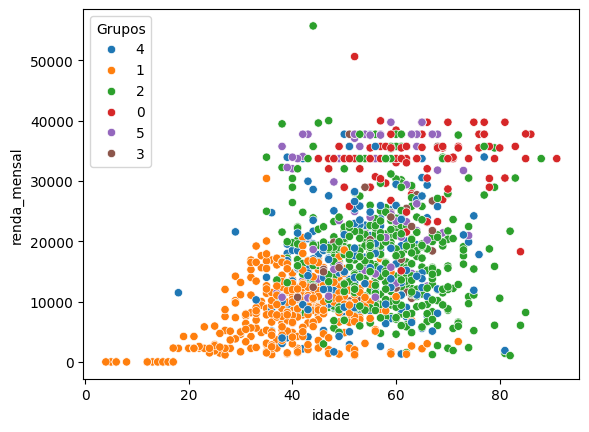

In [91]:
sns.scatterplot(
    data=df_2307,
    x='idade',
    y='renda_mensal',
    hue='Grupos'
)

## Coop - 2002

In [ ]:
df_2002 = df.query('cod_coop == "2002"')

df_cluster_2002 = df_2002\
    .loc[:, df_cluster_columns]\
    .drop(columns=['mc_cobranca'])

df_cluster_columns_2002 = df_cluster_2002.columns.tolist()
df_cluster_2002 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_2002),
    columns=df_cluster_columns_2002
    )

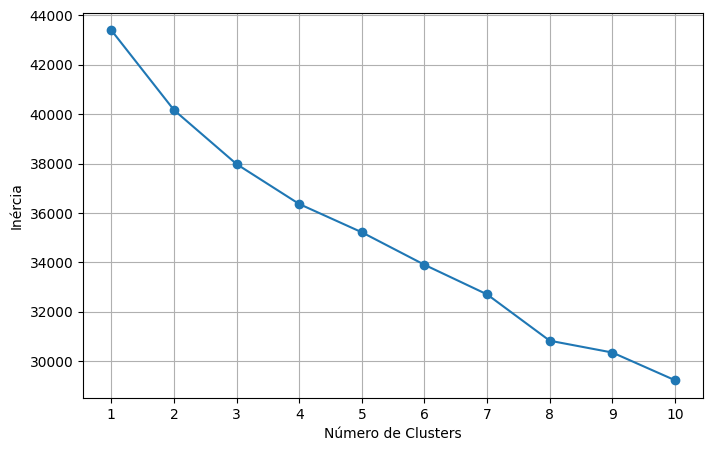

In [114]:
plot_inercia(df_cluster_2002)

In [115]:
choose_seed(df_cluster_2002, n_clusters=4)

Number of elements assigned to each cluster: [ 189    4 1203    4], 0
Number of elements assigned to each cluster: [100 994 238  68], 1
Number of elements assigned to each cluster: [ 182    2 1211    5], 2
Number of elements assigned to each cluster: [ 247  114    4 1035], 3
Number of elements assigned to each cluster: [ 172    4    8 1216], 4
Number of elements assigned to each cluster: [1044   35  101  220], 5
Number of elements assigned to each cluster: [ 249 1029    9  113], 6
Number of elements assigned to each cluster: [734 542 119   5], 7
Number of elements assigned to each cluster: [1034   18  105  243], 8
Number of elements assigned to each cluster: [ 122 1273    1    4], 9
Number of elements assigned to each cluster: [ 82 462 665 191], 10
Number of elements assigned to each cluster: [1044  109  246    1], 11
Number of elements assigned to each cluster: [1219  179    1    1], 12
Number of elements assigned to each cluster: [507 764  12 117], 13
Number of elements assigned to e

In [117]:
kmeans_2002 = KMeans(
    n_clusters=4,
    tol=1e-16,
    max_iter=5000,
    random_state=76
    ).fit(df_cluster_2002)
df_2002 = df_2002.assign(
    Grupos=kmeans_2002.labels_
).astype({'Grupos': str})

<Axes: ylabel='sld_seg_automovel'>

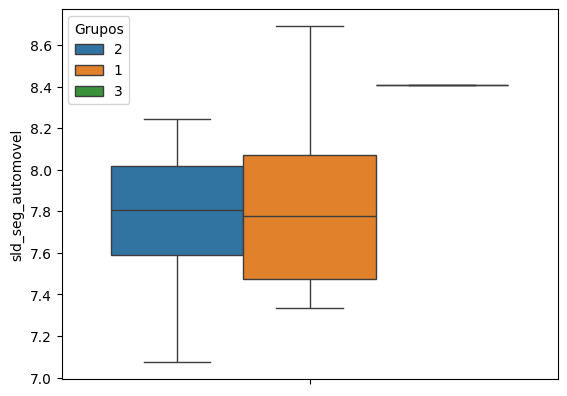

In [120]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_seg_automovel=lambda x: np.log1p(x.sld_seg_automovel)
        )\
        .query('sld_seg_automovel != 0'),
    y='sld_seg_automovel',
    hue='Grupos'
)

<Axes: ylabel='idade'>

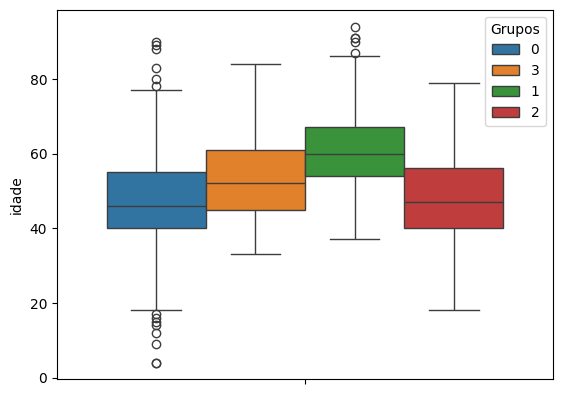

In [298]:
sns.boxplot(
    data=df_2002,
    y='idade',
    hue='Grupos'
)

<Axes: ylabel='renda_mensal'>

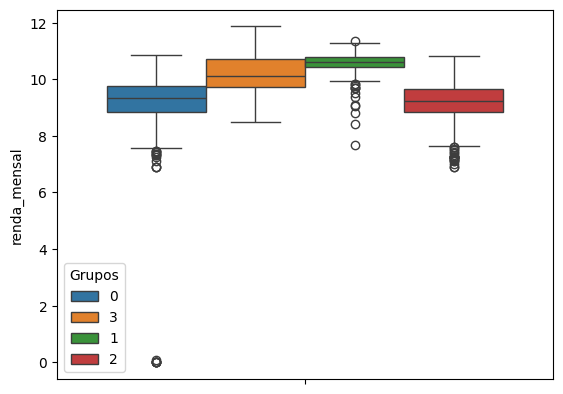

In [125]:
sns.boxplot(
    data=df_2002\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='renda_mensal',
    hue='Grupos'
)

<Axes: ylabel='tempo_assoc'>

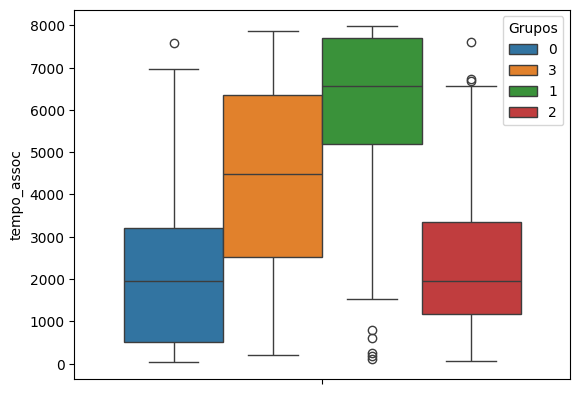

In [297]:
sns.boxplot(
    data=df_2002,
    y='tempo_assoc',
    hue='Grupos'
)

<Axes: ylabel='isa'>

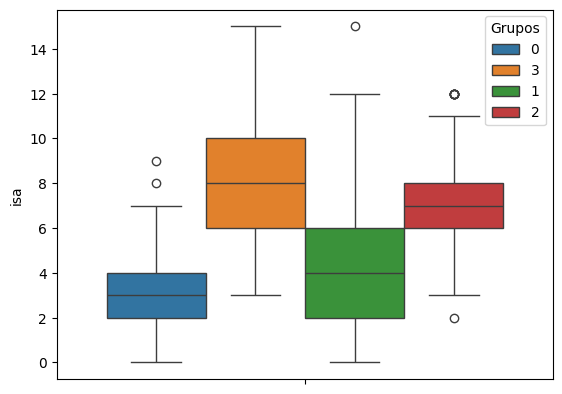

In [296]:
sns.boxplot(
    data=df_2002,
    y='isa',
    hue='Grupos'
)

<Axes: ylabel='sld_inad_ca_0'>

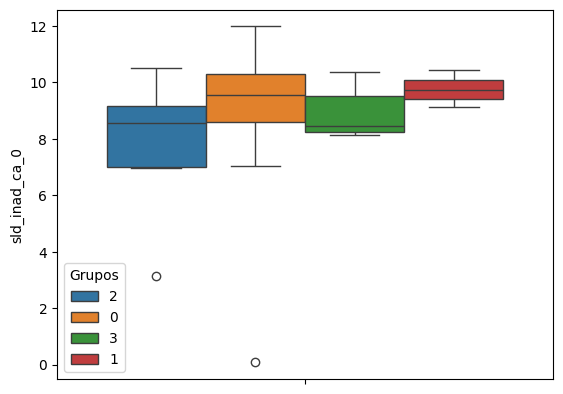

In [145]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_inad_ca_0=lambda x: np.log1p(x.sld_inad_ca_0)
        )\
        .query('sld_inad_ca_0 != 0'),
    y='sld_inad_ca_0',
    hue='Grupos'
)

<Axes: ylabel='sld_cred_comercial'>

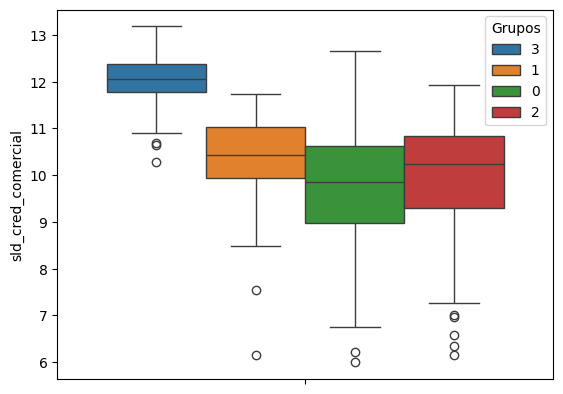

In [141]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_cred_comercial=lambda x: np.log1p(x.sld_cred_comercial)
        )\
        .query('sld_cred_comercial != 0'),
    y='sld_cred_comercial',
    hue='Grupos'
)

<Axes: ylabel='sld_previdencia'>

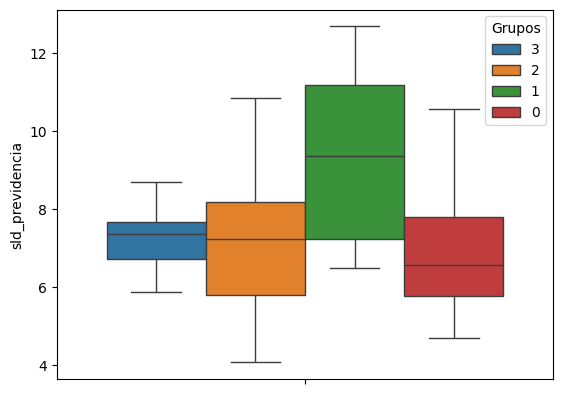

In [121]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: ylabel='sld_poupanca'>

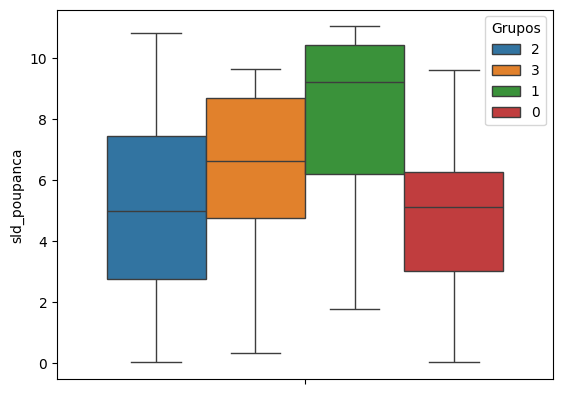

In [122]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca)
        )\
        .query('sld_poupanca != 0'),
        
    y='sld_poupanca',
    hue='Grupos'
)

<Axes: ylabel='prej_total'>

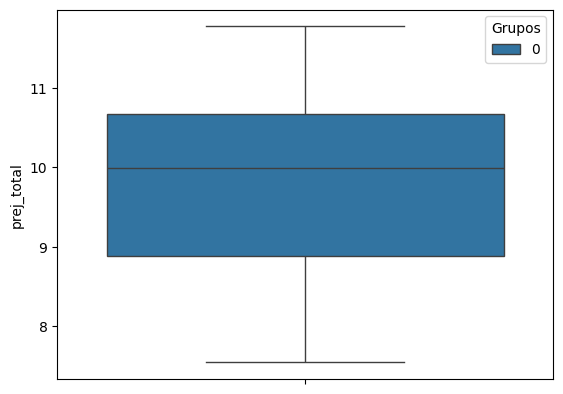

In [126]:
sns.boxplot(
    data=df_2002\
        .assign(
            prej_total=lambda x: np.log1p(x.loc[:, x.columns.str.startswith('vlr_prej')].sum(axis=1))
        )\
        .query('prej_total != 0'),
    y='prej_total',
    hue='Grupos'
)

<Axes: ylabel='sld_inad_ca_0'>

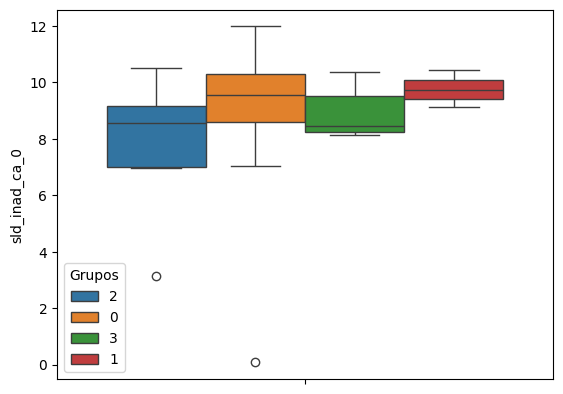

In [127]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_inad_ca_0=lambda x: np.log1p(x.sld_inad_ca_0)
        )\
        .query('sld_inad_ca_0 != 0'),
    y='sld_inad_ca_0',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_vida'>

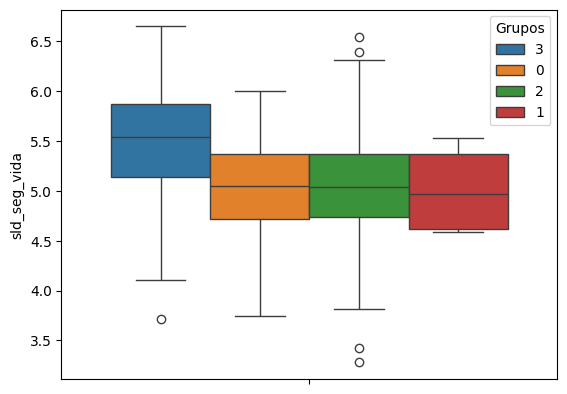

In [137]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida) 
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='Grupos'
)

<Axes: >

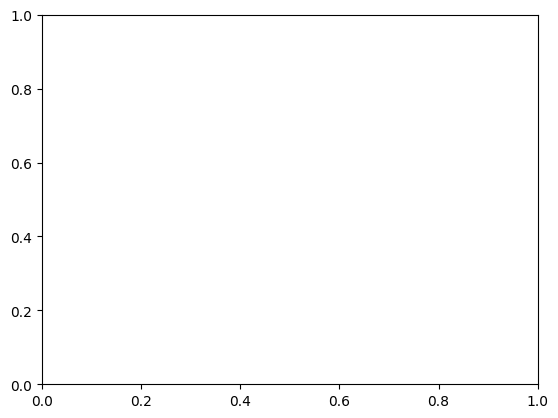

In [136]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_seg_patrimonial=lambda x: np.log1p(x.sld_seg_patrimonial) 
        )\
        .query('sld_seg_patrimonial != 0'),
    y='sld_seg_patrimonial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_residencial'>

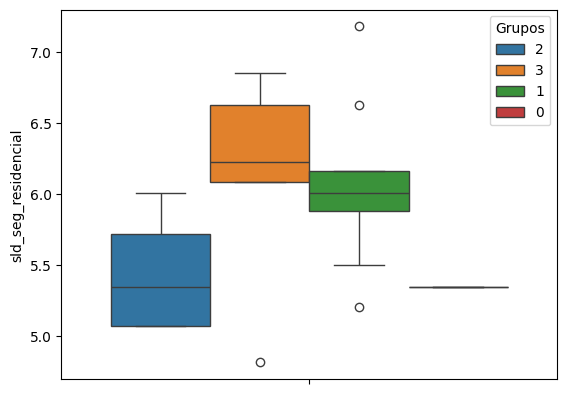

In [135]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_seg_residencial=lambda x: np.log1p(x.sld_seg_residencial) 
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_prestamista'>

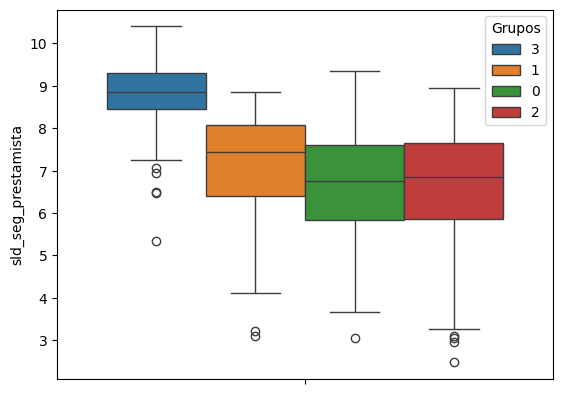

In [134]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_seg_prestamista=lambda x: np.log1p(x.sld_seg_prestamista) 
        )\
        .query('sld_seg_prestamista != 0'),
    y='sld_seg_prestamista',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

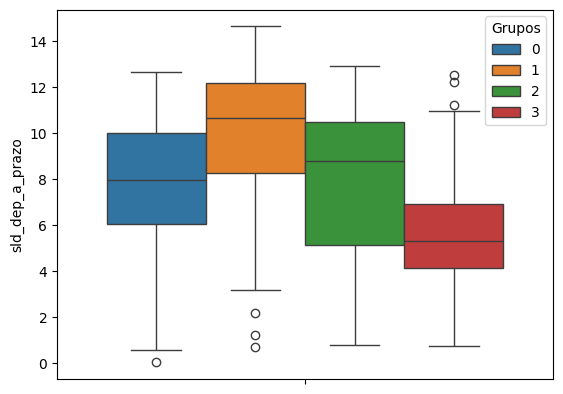

In [133]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo) 
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

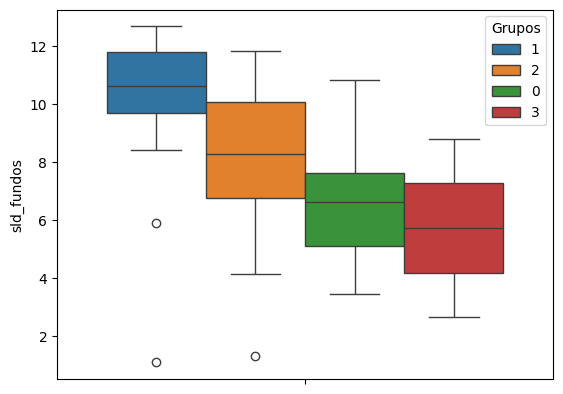

In [132]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos) 
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

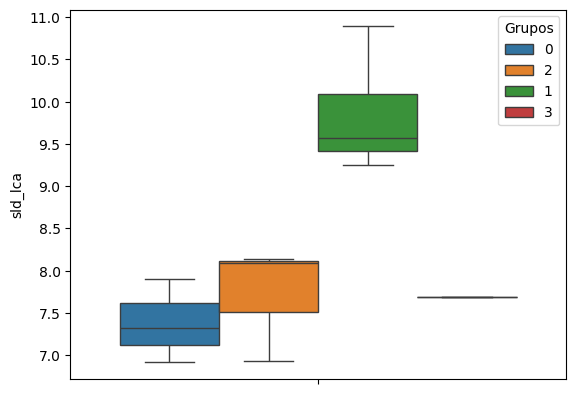

In [131]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_lca=lambda x: np.log1p(x.sld_lca) 
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: >

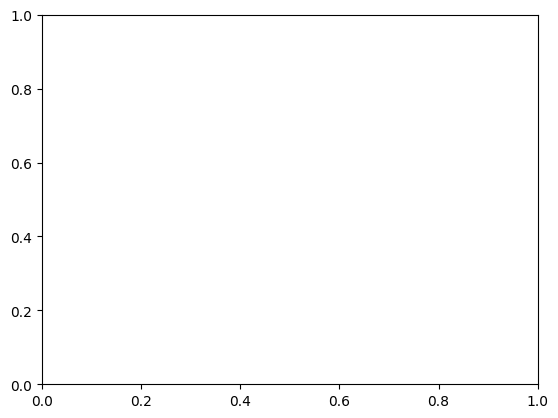

In [292]:
sns.boxplot(
    data=df_2002\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lci) 
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='Grupos'
)

<Axes: ylabel='investimento_total'>

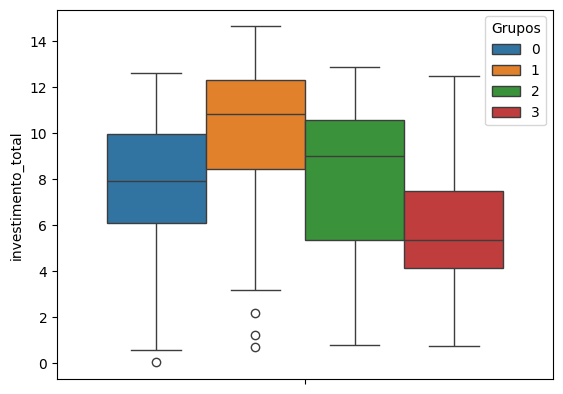

In [294]:
sns.boxplot(
    data=df_2002\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total)
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos'
)

<Axes: xlabel='idade', ylabel='renda_mensal'>

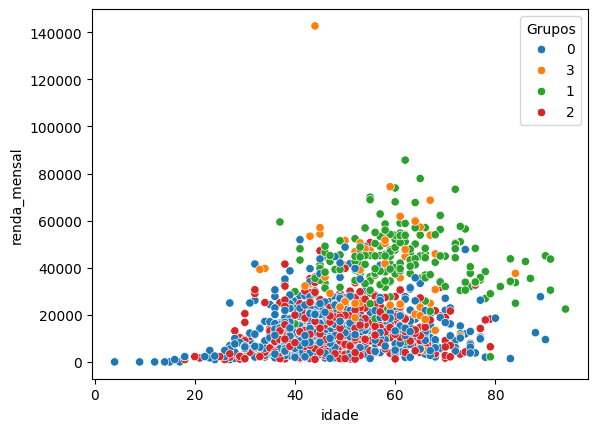

In [295]:
sns.scatterplot(
    data=df_2002,
    x='idade',
    y='renda_mensal',
    hue='Grupos'
)

## Coop - 2004

In [160]:
df_2004 = df.query('cod_coop == "2004"')

df_cluster_2004 = df_2004\
    .loc[:, df_cluster_columns]\
    .drop(columns=['mc_seguro_residencial'])

df_cluster_columns_2004 = df_cluster_2004.columns.tolist()
df_cluster_2004 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_2004),
    columns=df_cluster_columns_2004
    )

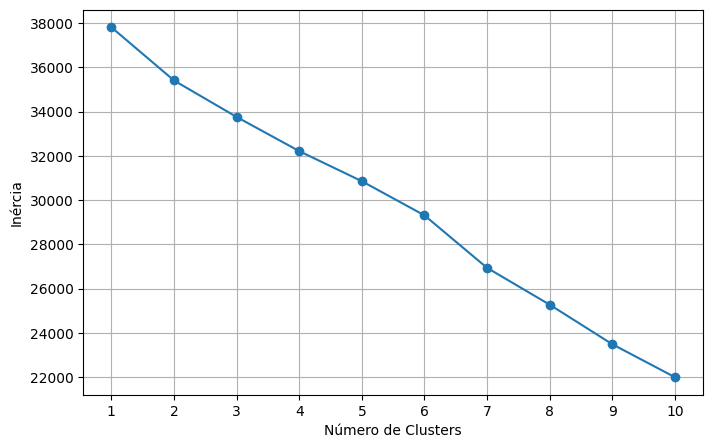

In [168]:
plot_inercia(df_cluster_2004)

In [179]:
choose_seed(df_cluster_2004, n_clusters=5)

Number of elements assigned to each cluster: [479   1 738   1   1], 0
Number of elements assigned to each cluster: [   1 1215    2    1    1], 1
Number of elements assigned to each cluster: [751   1 466   1   1], 2
Number of elements assigned to each cluster: [  2 610 135 472   1], 3
Number of elements assigned to each cluster: [473 744   1   1   1], 4
Number of elements assigned to each cluster: [1068    1    1  149    1], 5
Number of elements assigned to each cluster: [606   1 145 467   1], 6
Number of elements assigned to each cluster: [175 116 539   1 389], 7
Number of elements assigned to each cluster: [   2 1215    1    1    1], 8
Number of elements assigned to each cluster: [475   1 741   1   2], 9
Number of elements assigned to each cluster: [144 607   1   1 467], 10
Number of elements assigned to each cluster: [612 134   1   1 472], 11
Number of elements assigned to each cluster: [141 470 604   4   1], 12
Number of elements assigned to each cluster: [ 20 592 141   1 466], 13
N

In [181]:
kmeans_2004 = KMeans(
    n_clusters=5,
    tol=1e-16,
    max_iter=5000,
    random_state=7
    ).fit(df_cluster_2004)
df_2004 = df_2004.assign(
    Grupos=kmeans_2004.labels_
).astype({'Grupos': str})

<Axes: xlabel='idade', ylabel='renda_mensal'>

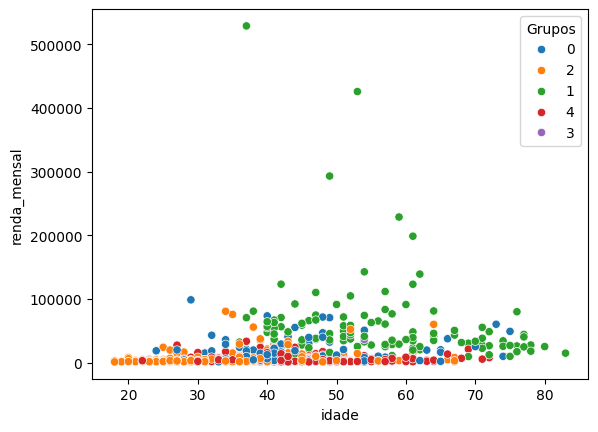

In [186]:
sns.scatterplot(
    data=df_2004,
    x='idade',
    y='renda_mensal',
    hue='Grupos'
)

<Axes: ylabel='investimento_total'>

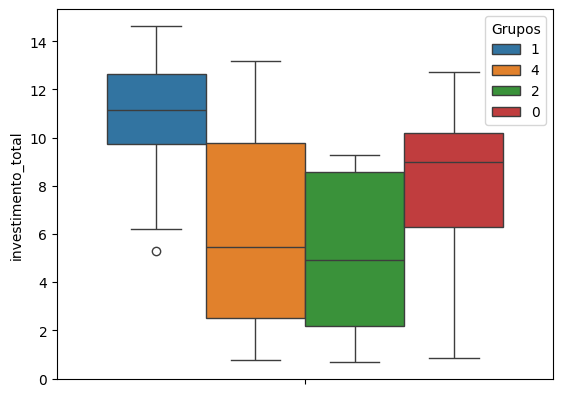

In [188]:
sns.boxplot(
    data=df_2004\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total)
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos'
)

<Axes: ylabel='isa'>

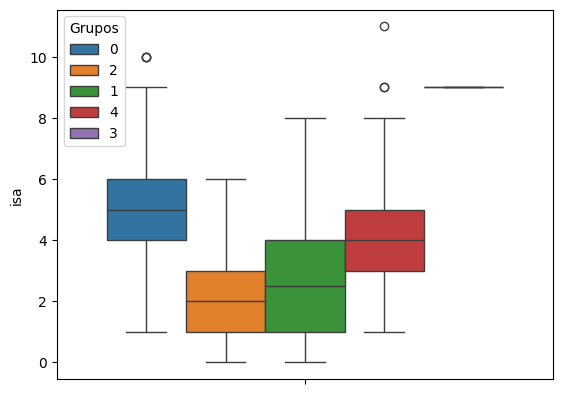

In [194]:
sns.boxplot(
    data=df_2004,
    y='isa',
    hue='Grupos'
)

In [ ]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_seg_patrimonial=lambda x: np.log1p(x.sld_seg_patrimonial) 
        )\
        .query('sld_seg_patrimonial != 0'),
    y='sld_seg_patrimonial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_patrimonial'>

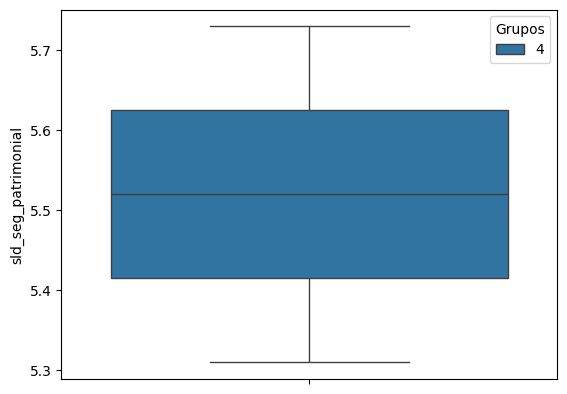

In [206]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_seg_patrimonial=lambda x: np.log1p(x.sld_seg_patrimonial) 
        )\
        .query('sld_seg_patrimonial != 0'),
    y='sld_seg_patrimonial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_prestamista'>

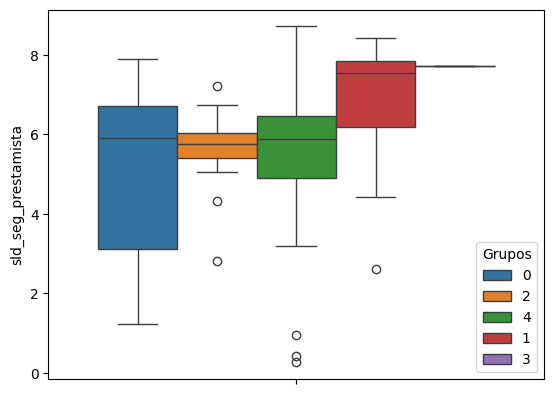

In [204]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_seg_prestamista=lambda x: np.log1p(x.sld_seg_prestamista) 
        )\
        .query('sld_seg_prestamista != 0'),
    y='sld_seg_prestamista',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

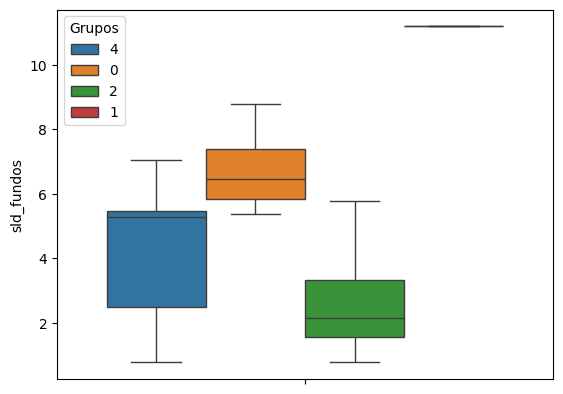

In [202]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos) 
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_vista'>

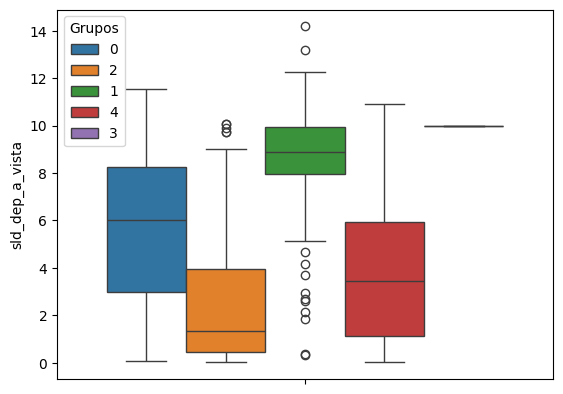

In [193]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_dep_a_vista=lambda x: np.log1p(x.sld_dep_a_vista) 
        )\
        .query('sld_dep_a_vista != 0'),
    y='sld_dep_a_vista',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

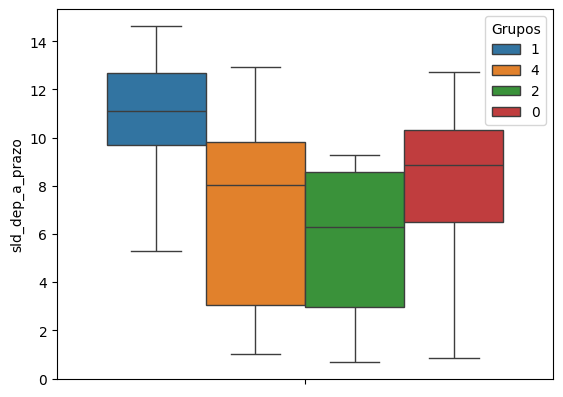

In [192]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo) 
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

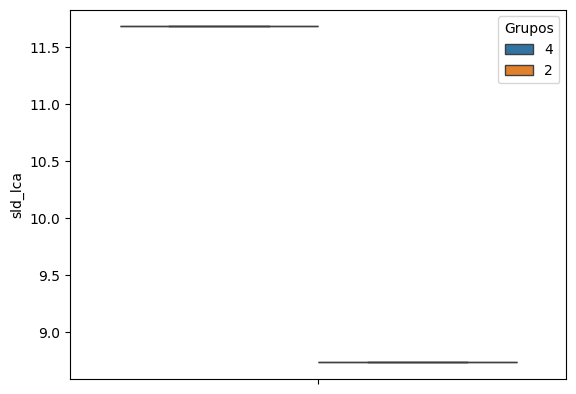

In [190]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_lca=lambda x: np.log1p(x.sld_lca) 
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: ylabel='investimento_total'>

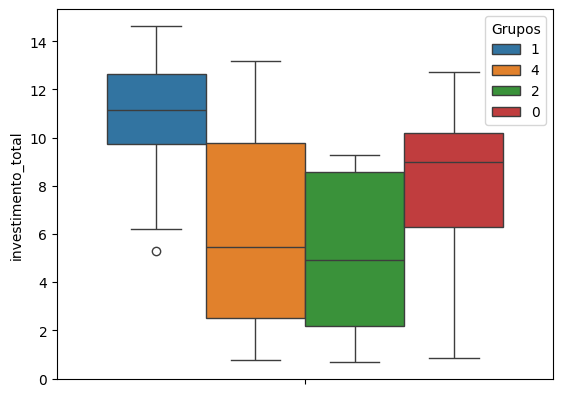

In [191]:
sns.boxplot(
    data=df_2004\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total) 
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos'
)

<Axes: ylabel='prej_total'>

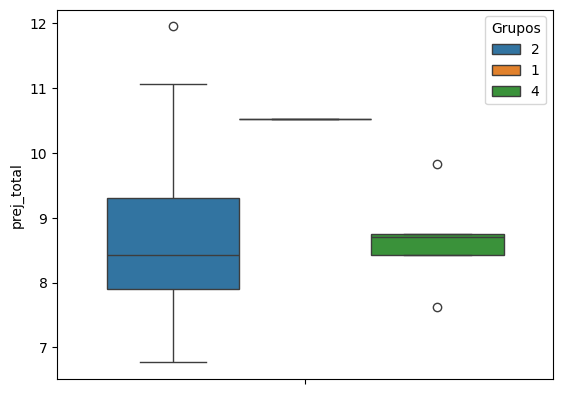

In [207]:
sns.boxplot(
    data=df_2004\
        .assign(
            prej_total=lambda x: np.log1p(x.loc[:, x.columns.str.startswith('vlr_prej')].sum(axis=1))
        )\
        .query('prej_total != 0'),
    y='prej_total',
    hue='Grupos'
)

<Axes: ylabel='sld_inad_ca_0'>

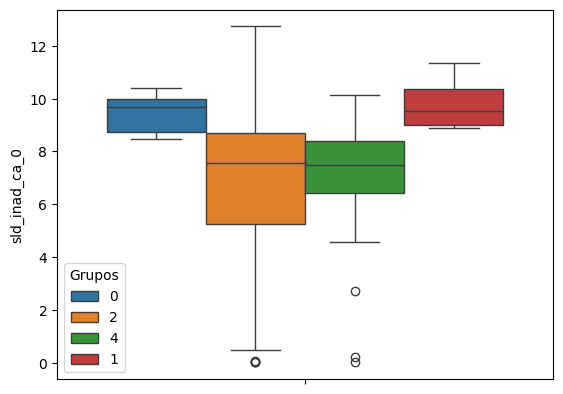

In [211]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_inad_ca_0=lambda x: np.log1p(x.sld_inad_ca_0) 
        )\
        .query('sld_inad_ca_0 != 0'),
    y='sld_inad_ca_0',
    hue='Grupos'
)

<Axes: ylabel='sld_cred_comercial'>

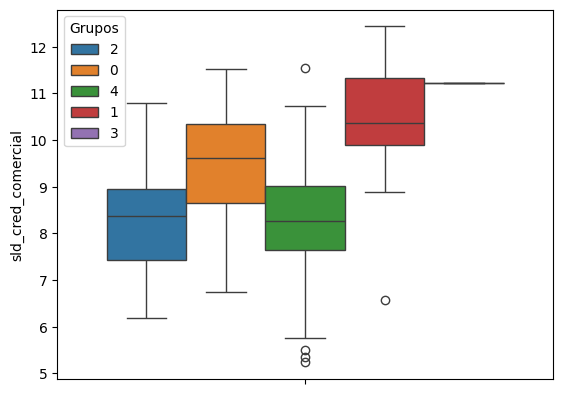

In [210]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_cred_comercial=lambda x: np.log1p(x.sld_cred_comercial) 
        )\
        .query('sld_cred_comercial != 0'),
    y='sld_cred_comercial',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_vida'>

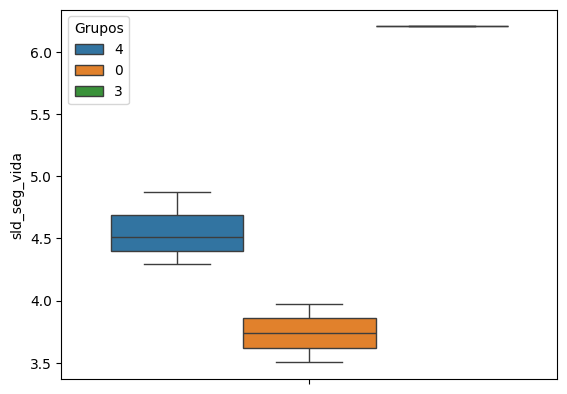

In [208]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida) 
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='Grupos'
)

<Axes: >

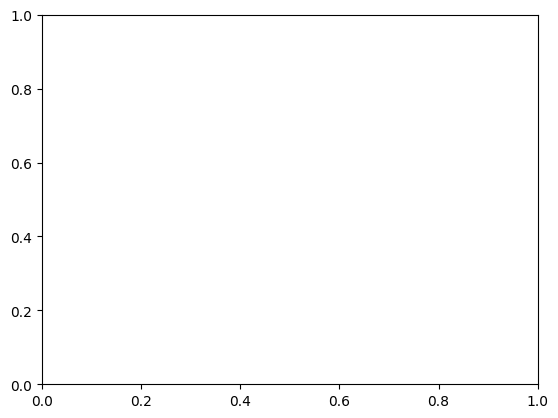

In [189]:
sns.boxplot(
    data=df_2004\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lci) 
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='Grupos'
)

## Coop - 2211

In [266]:
df_2211 = df.query('cod_coop == "2211"')

df_cluster_2211 = df_2211\
    .loc[:, df_cluster_columns]\
    .drop(columns=['mc_seguro_residencial'])
df_cluster_2211 = df_cluster_2211\
    .drop(
        columns=df_cluster_2211.columns[df_cluster_2211.columns.str.startswith('mc_')]
    )

df_cluster_columns_2211 = df_cluster_2211.columns.tolist()
df_cluster_2211 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_2211),
    columns=df_cluster_columns_2211
    )

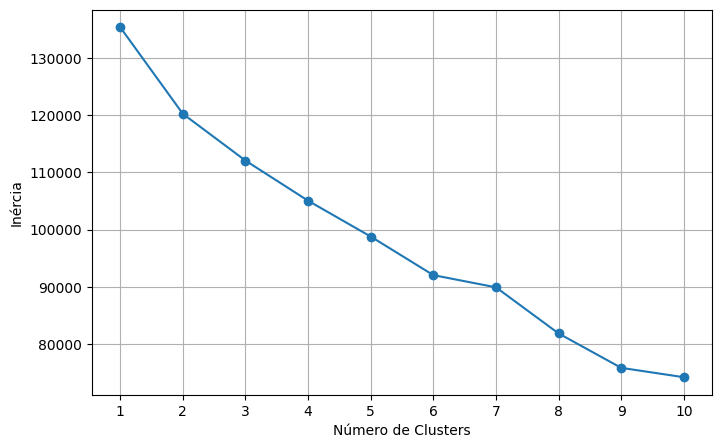

In [267]:
plot_inercia(df_cluster_2211)

In [268]:
choose_seed(df_cluster_2211, n_clusters=5)

Number of elements assigned to each cluster: [4353 1786 2693  194    1], 0
Number of elements assigned to each cluster: [ 194 4353 2687    1 1792], 1
Number of elements assigned to each cluster: [1825    1 2708 4350  143], 2
Number of elements assigned to each cluster: [4265 1523  672 2561    6], 3
Number of elements assigned to each cluster: [4465 2744 1560  257    1], 4
Number of elements assigned to each cluster: [2794   92  258 1551 4332], 5
Number of elements assigned to each cluster: [1818 4360    1  143 2705], 6
Number of elements assigned to each cluster: [4454 2739 1575  258    1], 7
Number of elements assigned to each cluster: [2796 4533   88 1609    1], 8
Number of elements assigned to each cluster: [1878 2492  191 3675  791], 9
Number of elements assigned to each cluster: [  87  606 2535 4257 1542], 10
Number of elements assigned to each cluster: [ 693    6 2349 5745  234], 11
Number of elements assigned to each cluster: [2795 1704 4485    3   40], 12
Number of elements ass

In [269]:
kmeans_2211 = KMeans(
    n_clusters=5,
    tol=1e-16,
    max_iter=5000,
    random_state=95
    ).fit(df_cluster_2211)
df_2211 = df_2211.assign(
    Grupos=kmeans_2211.labels_
)\
.sort_values('Grupos')\
.astype({'Grupos': str})

<Axes: xlabel='tempo_assoc', ylabel='renda_mensal'>

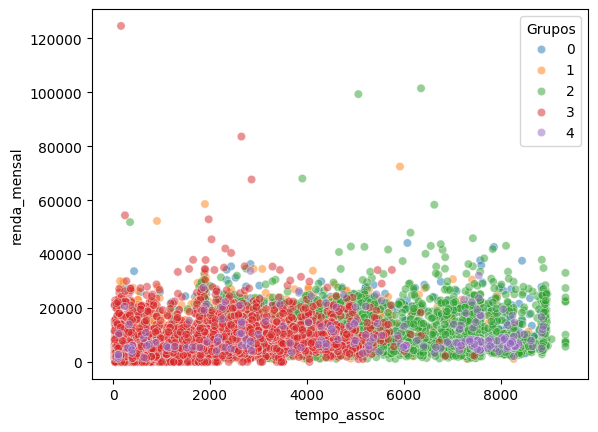

In [270]:
sns.scatterplot(
    data=df_2211\
        .query('renda_mensal < 1e6'),
    x='tempo_assoc',
    y='renda_mensal',
    hue='Grupos',
    alpha=.5
)

<Axes: ylabel='renda_mensal'>

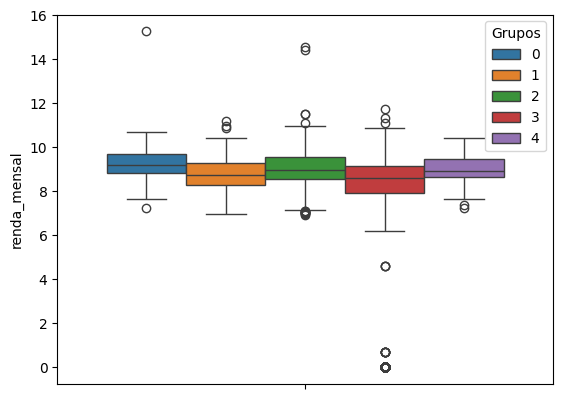

In [271]:
sns.boxplot(
    data=df_2211\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='renda_mensal',
    hue='Grupos'
)

<Axes: ylabel='idade'>

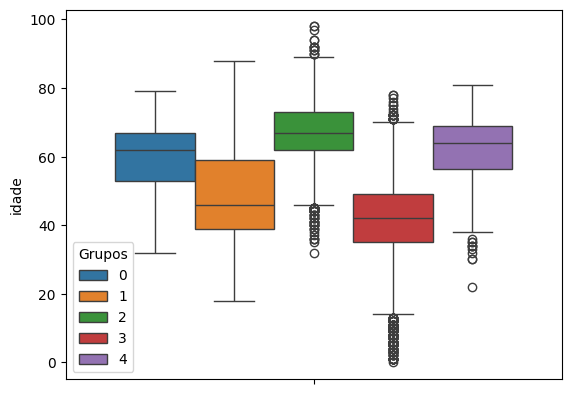

In [272]:
sns.boxplot(
    data=df_2211,
    y='idade',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

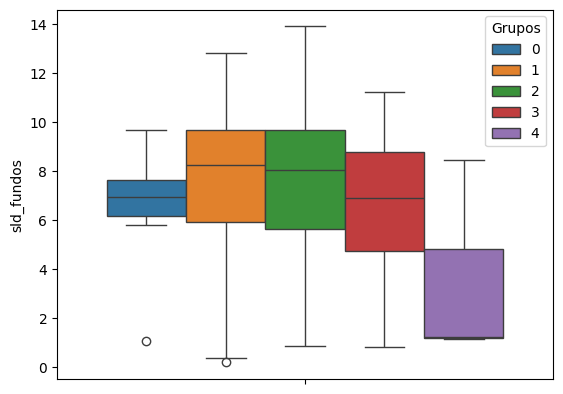

In [273]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

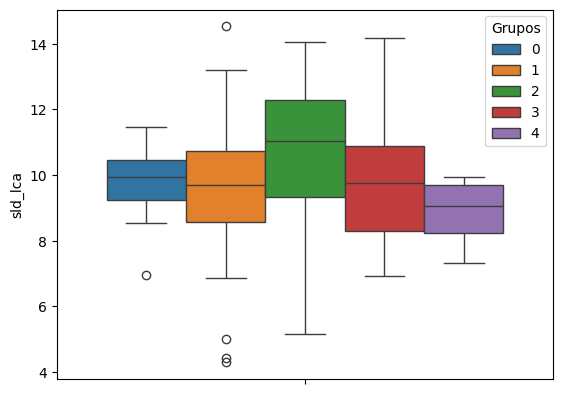

In [274]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_lca=lambda x: np.log1p(x.sld_lca)
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: >

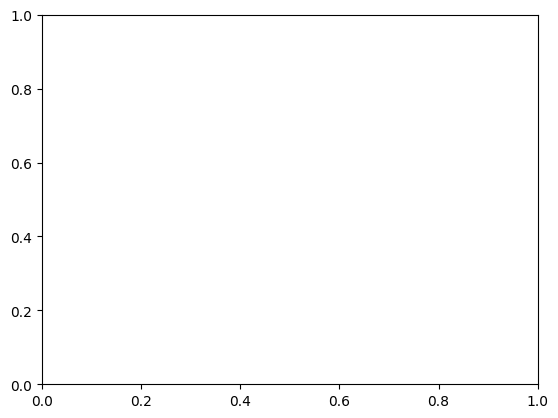

In [275]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lci)
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

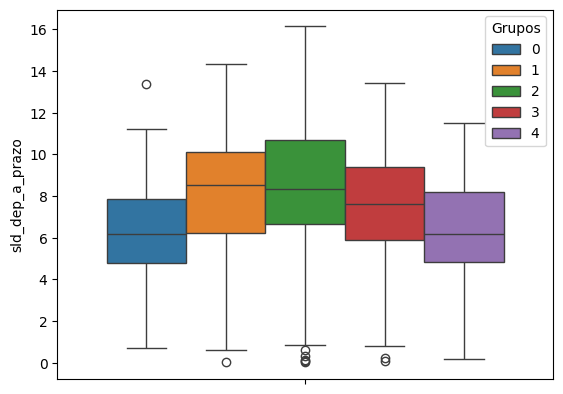

In [276]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo) 
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_vida'>

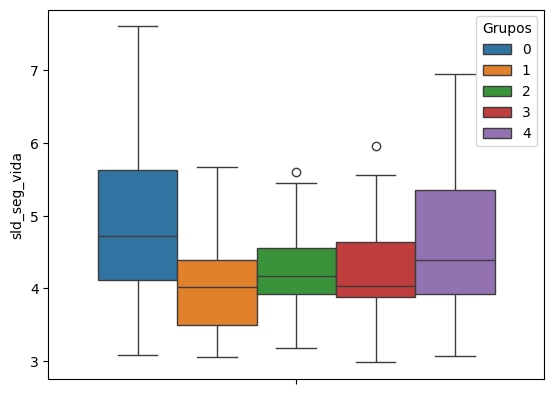

In [277]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_seg_vida=lambda x: np.log1p(x.sld_seg_vida) 
        )\
        .query('sld_seg_vida != 0'),
    y='sld_seg_vida',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_automovel'>

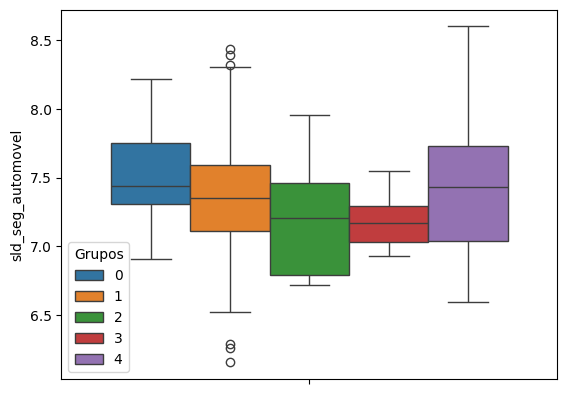

In [278]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_seg_automovel=lambda x: np.log1p(x.sld_seg_automovel) 
        )\
        .query('sld_seg_automovel != 0'),
    y='sld_seg_automovel',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_prestamista'>

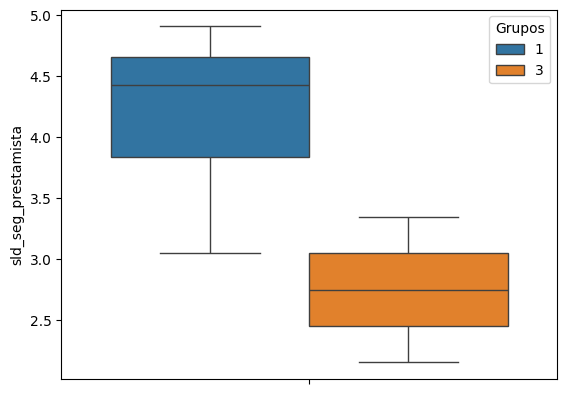

In [279]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_seg_prestamista=lambda x: np.log1p(x.sld_seg_prestamista) 
        )\
        .query('sld_seg_prestamista != 0'),
    y='sld_seg_prestamista',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_residencial'>

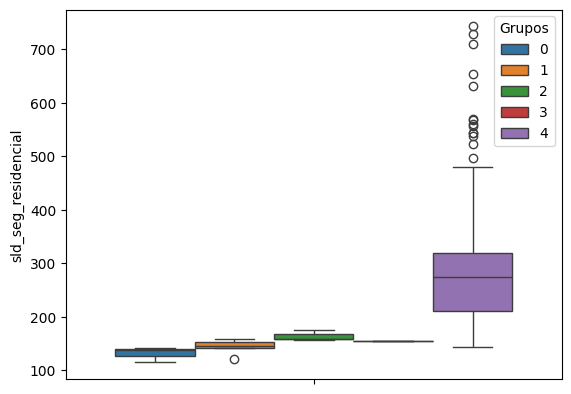

In [305]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_seg_residencial=lambda x: x.sld_seg_residencial
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='Grupos'
)

<Axes: ylabel='sld_previdencia'>

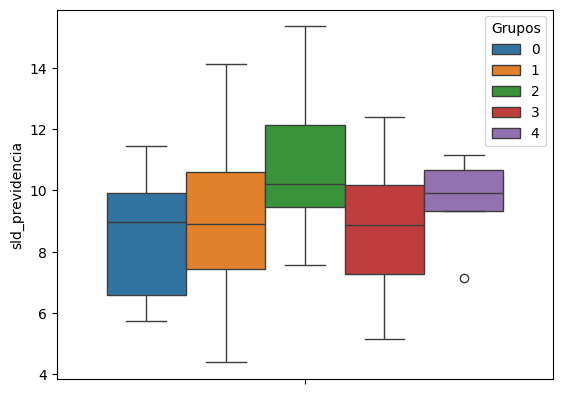

In [303]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia) 
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: ylabel='sld_poupanca'>

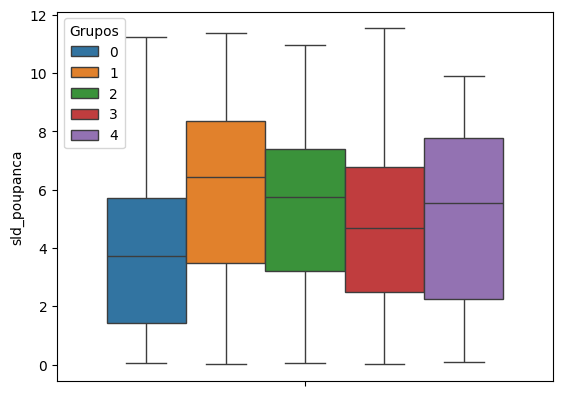

In [302]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca) 
        )\
        .query('sld_poupanca != 0'),
    y='sld_poupanca',
    hue='Grupos'
)

<Axes: ylabel='sld_capital_social'>

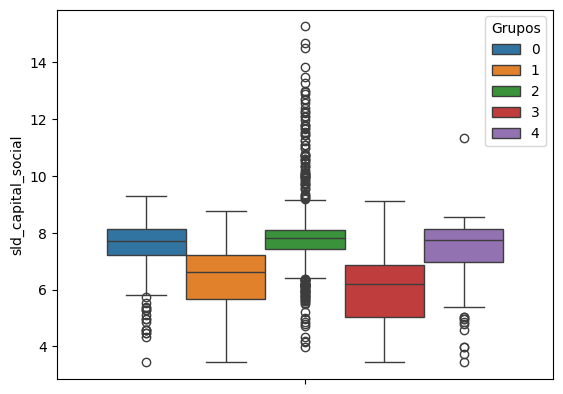

In [301]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_capital_social=lambda x: np.log1p(x.sld_capital_social) 
        )\
        .query('sld_capital_social != 0'),
    y='sld_capital_social',
    hue='Grupos'
)

<Axes: ylabel='sld_cred_comercial'>

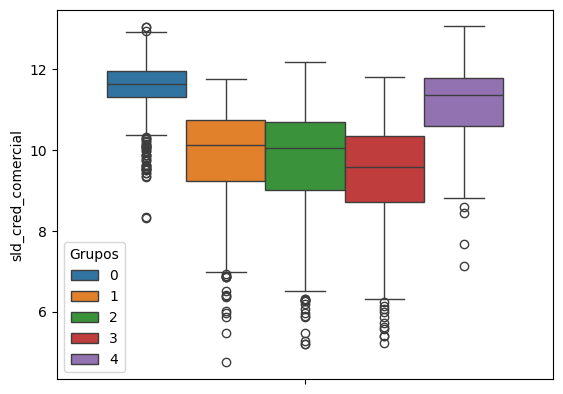

In [300]:
sns.boxplot(
    data=df_2211\
        .assign(
            sld_cred_comercial=lambda x: np.log1p(x.sld_cred_comercial) 
        )\
        .query('sld_cred_comercial != 0'),
    y='sld_cred_comercial',
    hue='Grupos'
)

## Coop - 2003

In [323]:
df_2003 = df.query('cod_coop == "2003"')

df_cluster_2003 = df_2003\
    .loc[:, df_cluster_columns]
df_cluster_2003 = df_cluster_2003\
    .drop(
        columns=df_cluster_2003.columns[
            df_cluster_2003.columns.str.startswith('mc_')
        ]
    )

df_cluster_columns_2003 = df_cluster_2003.columns.tolist()
df_cluster_2003 = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster_2003),
    columns=df_cluster_columns_2003
    )

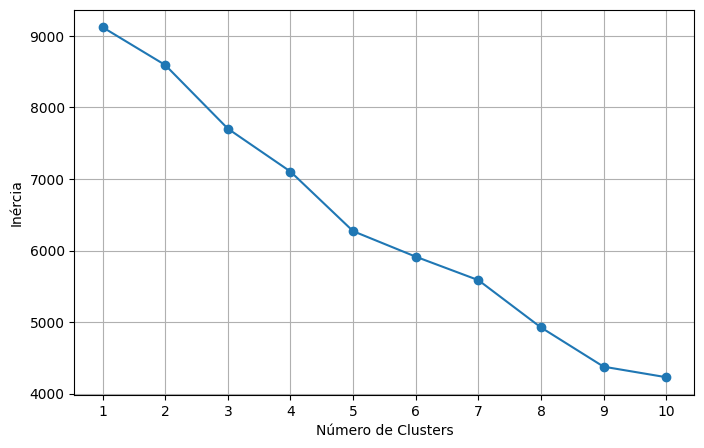

In [325]:
plot_inercia(df_cluster_2003)

In [327]:
choose_seed(df_cluster_2003, n_clusters=5)

Number of elements assigned to each cluster: [ 14 164 162 267   1], 0
Number of elements assigned to each cluster: [153 217 197  39   2], 1
Number of elements assigned to each cluster: [216 154 198  37   3], 2
Number of elements assigned to each cluster: [ 15  64 321 180  28], 3
Number of elements assigned to each cluster: [194 344   1  68   1], 4
Number of elements assigned to each cluster: [196 157   1  38 216], 5
Number of elements assigned to each cluster: [535   1   1  10  61], 6
Number of elements assigned to each cluster: [222 178 183  24   1], 7
Number of elements assigned to each cluster: [167 164  14 262   1], 8
Number of elements assigned to each cluster: [ 14 173 239   1 181], 9
Number of elements assigned to each cluster: [167 165 261   1  14], 10
Number of elements assigned to each cluster: [205 176  28  50 149], 11
Number of elements assigned to each cluster: [221 344  37   1   5], 12
Number of elements assigned to each cluster: [168 239   1   1 199], 13
Number of elemen

In [328]:
kmeans_2003 = KMeans(
    n_clusters=5,
    tol=1e-16,
    max_iter=5000,
    random_state=96
    ).fit(df_cluster_2003)
df_2003 = df_2003.assign(
    Grupos=kmeans_2003.labels_
)\
.sort_values('Grupos')\
.astype({'Grupos': str})

<Axes: ylabel='sld_cred_comercial'>

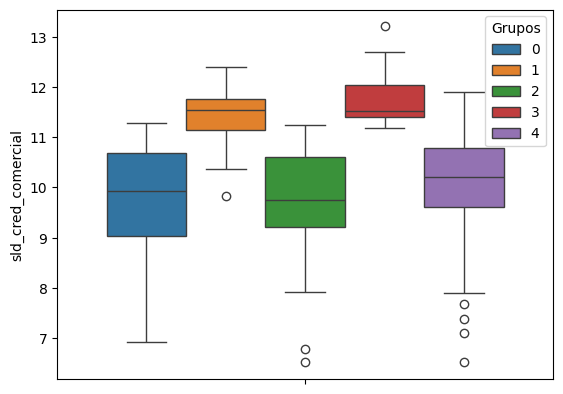

In [330]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_cred_comercial=lambda x: np.log1p(x.sld_cred_comercial) 
        )\
        .query('sld_cred_comercial != 0'),
    y='sld_cred_comercial',
    hue='Grupos'
)

<Axes: ylabel='sld_capital_social'>

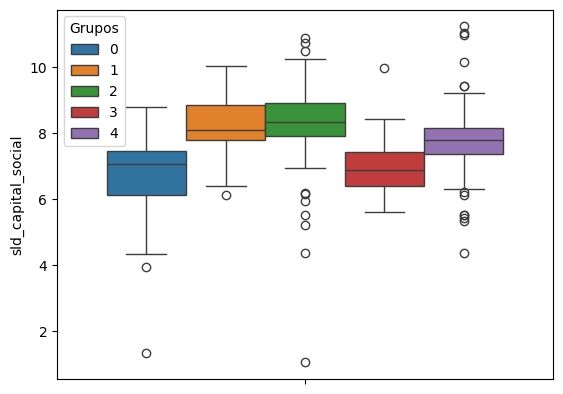

In [331]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_capital_social=lambda x: np.log1p(x.sld_capital_social) 
        )\
        .query('sld_capital_social != 0'),
    y='sld_capital_social',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_patrimonial'>

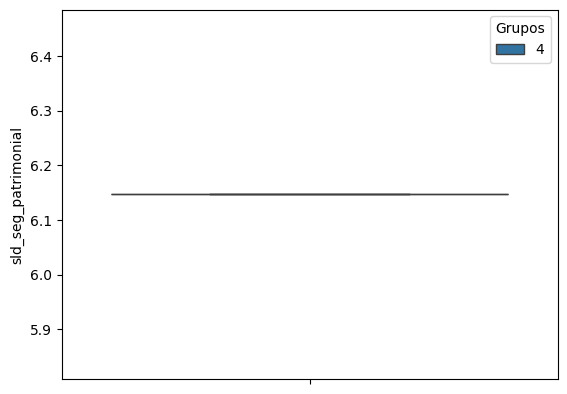

In [341]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_seg_patrimonial=lambda x: np.log1p(x.sld_seg_patrimonial)
        )\
        .query('sld_seg_patrimonial != 0'),
    y='sld_seg_patrimonial',
    hue='Grupos'
)

<Axes: ylabel='investimento_total'>

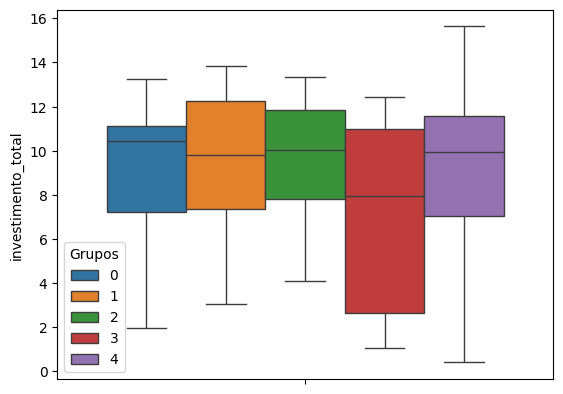

In [ ]:
sns.boxplot(
    data=df_2003\
        .assign(
            investimento_total=lambda x: np.log1p(x.investimento_total)
        )\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

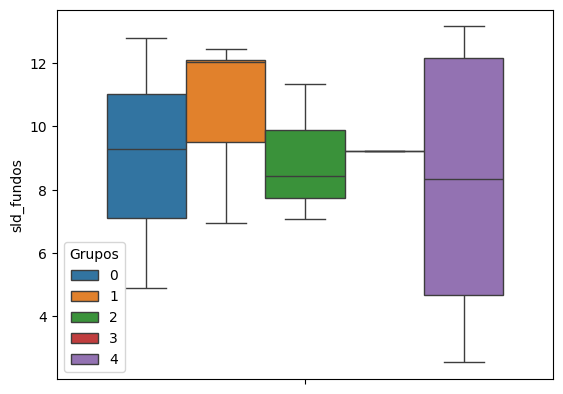

In [338]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_seg_residencial'>

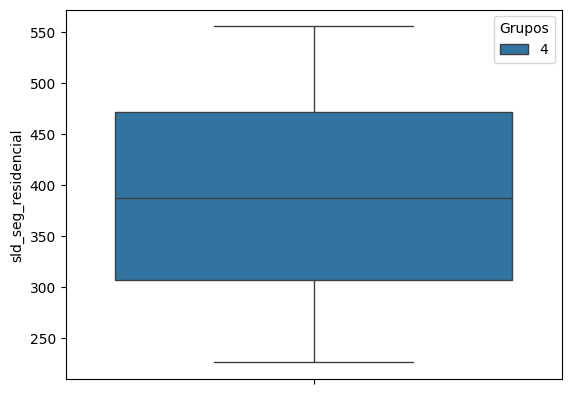

In [336]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_seg_residencial=lambda x: x.sld_seg_residencial
        )\
        .query('sld_seg_residencial != 0'),
    y='sld_seg_residencial',
    hue='Grupos'
)

<Axes: ylabel='sld_poupanca'>

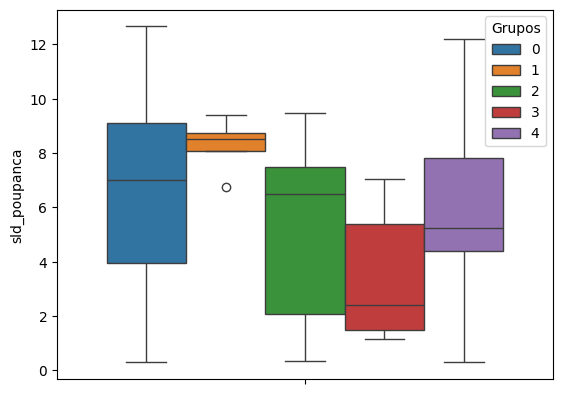

In [335]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_poupanca=lambda x: np.log1p(x.sld_poupanca) 
        )\
        .query('sld_poupanca != 0'),
    y='sld_poupanca',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

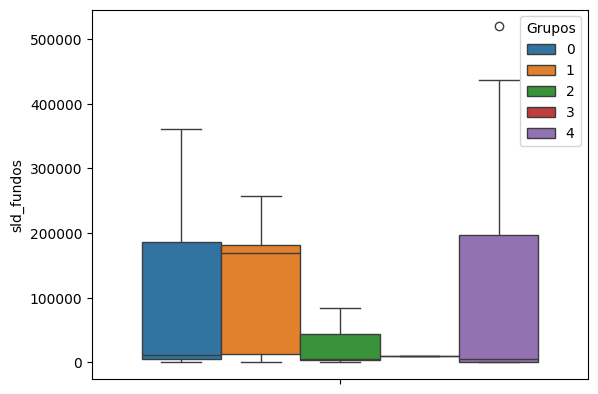

In [ ]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos) 
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: >

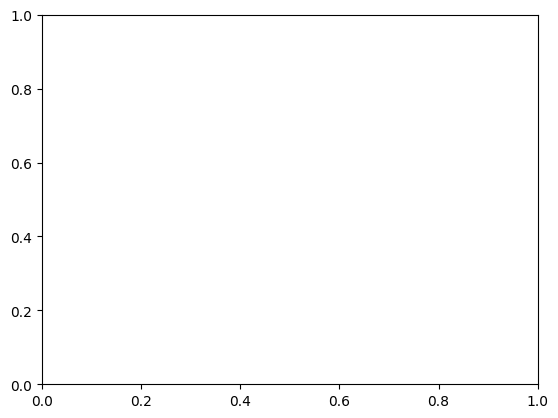

In [344]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_lci=lambda x: np.log1p(x.sld_lci) 
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='Grupos'
)

<Axes: ylabel='sld_lca'>

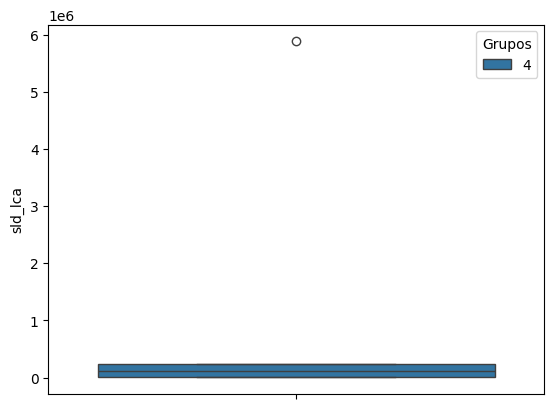

In [358]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_lca=lambda x: x.sld_lca 
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: ylabel='sld_inad_ca_0'>

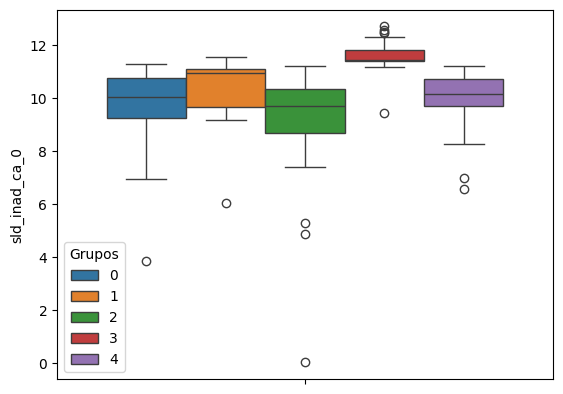

In [ ]:
sns.boxplot(
    data=df_2003\
        .assign(
            sld_inad_ca_0=lambda x: np.log1p(x.sld_inad_ca_0) 
        )\
        .query('sld_inad_ca_0 != 0'),
    y='sld_inad_ca_0',
    hue='Grupos'
)

<Axes: ylabel='renda_mensal'>

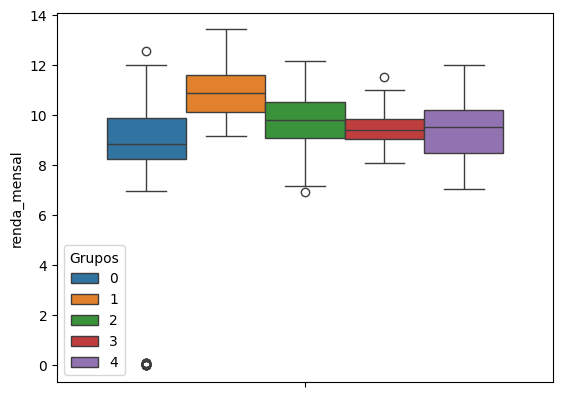

In [334]:
sns.boxplot(
    data=df_2003\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='renda_mensal',
    hue='Grupos'
)

<Axes: ylabel='idade'>

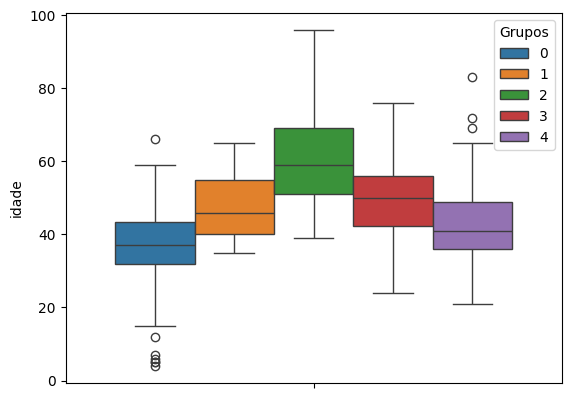

In [332]:
sns.boxplot(
    data=df_2003,
    y='idade',
    hue='Grupos'
)